# *Customer Segmentation avec machine learning*

## **Étape 1 : Charger le jeu de données**

In [1]:
# Chargement des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
import pickle

In [2]:
# Étape 1 : Charger le jeu de données
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print("\nPremières 5 lignes :")
print(data.head())


Premières 5 lignes :
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovie

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
print(data.shape)

(7043, 21)


In [5]:
print("Duplicate customerIDs:", data['customerID'].duplicated().sum())

Duplicate customerIDs: 0


Aucun identifiant client (« customerID ») n’est dupliqué dans le jeu de données, ce qui garantit l’unicité de chaque client pour l’analyse.

## **Étape 2 : Sélection des variables pour la segmentation**

In [6]:
features = ['SeniorCitizen', 'Contract', 'InternetService', 'PaymentMethod', 
           'PaperlessBilling', 'tenure', 'MonthlyCharges', 'TotalCharges', 
           'OnlineSecurity', 'StreamingTV']  
X = data[features]
print("\nSelected Features:", X.columns)


Selected Features: Index(['SeniorCitizen', 'Contract', 'InternetService', 'PaymentMethod',
       'PaperlessBilling', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'OnlineSecurity', 'StreamingTV'],
      dtype='object')


In [7]:
print(X.head())

   SeniorCitizen        Contract InternetService              PaymentMethod  \
0              0  Month-to-month             DSL           Electronic check   
1              0        One year             DSL               Mailed check   
2              0  Month-to-month             DSL               Mailed check   
3              0        One year             DSL  Bank transfer (automatic)   
4              0  Month-to-month     Fiber optic           Electronic check   

  PaperlessBilling  tenure  MonthlyCharges TotalCharges OnlineSecurity  \
0              Yes       1           29.85        29.85             No   
1               No      34           56.95       1889.5            Yes   
2              Yes       2           53.85       108.15            Yes   
3               No      45           42.30      1840.75            Yes   
4              Yes       2           70.70       151.65             No   

  StreamingTV  
0          No  
1          No  
2          No  
3          No  


Pour réaliser une segmentation pertinente des clients, il est important de sélectionner des variables à la fois démographiques, contractuelles et comportementales. Voici les variables choisies :

- **SeniorCitizen** : Indique si le client est un senior (0 = Non, 1 = Oui)
- **Contract** : Type de contrat (mensuel, annuel, etc.)
- **InternetService** : Type de service Internet souscrit
- **PaymentMethod** : Méthode de paiement utilisée
- **PaperlessBilling** : Facturation électronique (Oui/Non)
- **tenure** : Ancienneté du client (en mois)
- **MonthlyCharges** : Montant mensuel facturé
- **TotalCharges** : Total des dépenses du client
- **OnlineSecurity** : Souscription à la sécurité en ligne
- **StreamingTV** : Utilisation du service TV en streaming

Cette sélection permet de capturer la diversité des profils clients, en tenant compte de leur engagement, de leurs habitudes de consommation et de leurs préférences contractuelles.

## **Étape 3 : Gestion des valeurs manquantes**

In [8]:
# Vérifier les valeurs manquantes
print("Valeurs manquantes par colonne :")
print(X.isnull().sum())

Valeurs manquantes par colonne :
SeniorCitizen       0
Contract            0
InternetService     0
PaymentMethod       0
PaperlessBilling    0
tenure              0
MonthlyCharges      0
TotalCharges        0
OnlineSecurity      0
StreamingTV         0
dtype: int64


In [9]:
X.loc[:, 'TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')
print("\nMissing Values Before Imputation:")
print(X.isnull().sum())


Missing Values Before Imputation:
SeniorCitizen        0
Contract             0
InternetService      0
PaymentMethod        0
PaperlessBilling     0
tenure               0
MonthlyCharges       0
TotalCharges        11
OnlineSecurity       0
StreamingTV          0
dtype: int64


Explication :                                                                                                                                                                     
La colonne 'TotalCharges' était de type object (chaîne de caractères) car certaines valeurs étaient vides ou non numériques.
En utilisant pd.to_numeric(X['TotalCharges'], errors='coerce'), toutes les valeurs non convertibles (vides ou incorrectes) ont été remplacées par NaN.
Cela a généré 11 valeurs manquantes dans 'TotalCharges', correspondant aux clients dont cette colonne était vide dans le fichier d'origine.

In [10]:
X.loc[:, 'TotalCharges'] = X['TotalCharges'].fillna(X['TotalCharges'].median())
print("\nMissing Values After Imputation:")
print(X.isnull().sum())


Missing Values After Imputation:
SeniorCitizen       0
Contract            0
InternetService     0
PaymentMethod       0
PaperlessBilling    0
tenure              0
MonthlyCharges      0
TotalCharges        0
OnlineSecurity      0
StreamingTV         0
dtype: int64


C:\Users\dell\AppData\Local\Temp\ipykernel_11636\161994066.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:, 'TotalCharges'] = X['TotalCharges'].fillna(X['TotalCharges'].median())


Après le traitement des valeurs manquantes, notre jeu de données ne contient plus de valeurs nulles. Cela garantit la qualité des analyses et des modèles de machine learning qui suivront.

## **Étape 4 : Encodage des variables catégorielles**

In [11]:
# Identifier les colonnes catégorielles
categorical_cols = ['Contract', 'InternetService', 'PaymentMethod', 'SeniorCitizen',
                   'PaperlessBilling', 'OnlineSecurity', 'StreamingTV']
print("Colonnes catégorielles:", categorical_cols)

Colonnes catégorielles: ['Contract', 'InternetService', 'PaymentMethod', 'SeniorCitizen', 'PaperlessBilling', 'OnlineSecurity', 'StreamingTV']


In [12]:
# Appliquer one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print("\nEncoded Features:", X_encoded.columns)


Encoded Features: Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract_One year',
       'Contract_Two year', 'InternetService_Fiber optic',
       'InternetService_No', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'SeniorCitizen_1', 'PaperlessBilling_Yes',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes'],
      dtype='object')


In [13]:
print(X_encoded.head())

   tenure  MonthlyCharges TotalCharges  Contract_One year  Contract_Two year  \
0       1           29.85        29.85              False              False   
1      34           56.95       1889.5               True              False   
2       2           53.85       108.15              False              False   
3      45           42.30      1840.75               True              False   
4       2           70.70       151.65              False              False   

   InternetService_Fiber optic  InternetService_No  \
0                        False               False   
1                        False               False   
2                        False               False   
3                        False               False   
4                         True               False   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                  False                            True   
1                                  False  

L’encodage des variables catégorielles permet de transformer les colonnes non numériques (ex : type de contrat, méthode de paiement) en variables numériques exploitables par les algorithmes de machine learning, via des techniques comme le one-hot encoding.

## **Étape 5 : Standardisation des variables numériques**

In [15]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])
print("\nAperçu des données standardisées :")
print(X_encoded.head())


Aperçu des données standardisées :
     tenure  MonthlyCharges  TotalCharges  Contract_One year  \
0 -1.277445       -1.160323     -0.994242              False   
1  0.066327       -0.259629     -0.173244               True   
2 -1.236724       -0.362660     -0.959674              False   
3  0.514251       -0.746535     -0.194766               True   
4 -1.236724        0.197365     -0.940470              False   

   Contract_Two year  InternetService_Fiber optic  InternetService_No  \
0              False                        False               False   
1              False                        False               False   
2              False                        False               False   
3              False                        False               False   
4              False                         True               False   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                  False                        

 La standardisation permet de ramener les variables numériques à la même échelle (moyenne 0, écart-type 1),  
 ce qui améliore la performance et la convergence des algorithmes de machine learning sensibles à l’échelle des données.

In [16]:
# Sauvegarder le scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [17]:
# Vérifier les valeurs manquantes
print("Valeurs manquantes :", X_encoded.isnull().sum().sum())

# Vérifier les types de données
print("Types de données :", X_encoded.dtypes)

# Vérifier la forme des données prétraitées
print("Forme des données prétraitées :", X_encoded.shape)

Valeurs manquantes : 0
Types de données : tenure                                   float64
MonthlyCharges                           float64
TotalCharges                             float64
Contract_One year                           bool
Contract_Two year                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
PaymentMethod_Credit card (automatic)       bool
PaymentMethod_Electronic check              bool
PaymentMethod_Mailed check                  bool
SeniorCitizen_1                             bool
PaperlessBilling_Yes                        bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
StreamingTV_No internet service             bool
StreamingTV_Yes                             bool
dtype: object
Forme des données prétraitées : (7043, 16)


Après le prétraitement, notre jeu de données ne contient plus de valeurs manquantes et toutes les variables sont au format numérique ou booléen, prêtes pour l’analyse. La matrice finale comporte 16 variables explicatives et 7043 observations, ce qui garantit la qualité et la compatibilité des données pour les algorithmes de machine learning.

### **Étape 6: Application de PCA**


In [18]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_encoded)
print(f'\nPCA Components: {pca.n_components_}')
print(f'Explained Variance Ratio: {sum(pca.explained_variance_ratio_):.3f}')


PCA Components: 10
Explained Variance Ratio: 0.965


La réduction de dimensionnalité par ACP (PCA) a permis de conserver 10 composantes principales, expliquant 96,5 % de la variance totale des données. Cela signifie que l’essentiel de l’information initiale est préservé tout en simplifiant la structure des données, ce qui facilite la visualisation et améliore l’efficacité des algorithmes de clustering.

In [19]:
# Sauvegarder le modèle PCA et X_pca
with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)
pd.to_pickle(X_pca, 'X_pca.pkl')
with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)
pd.to_pickle(X_pca, 'X_pca.pkl')

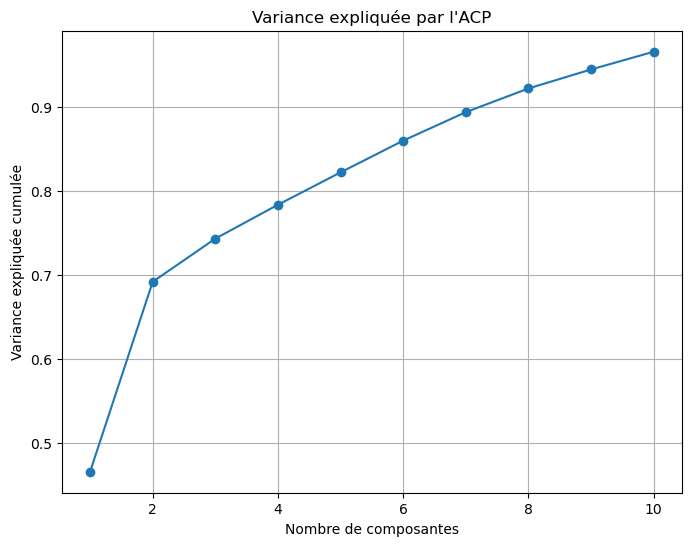

In [20]:
# Visualiser la variance expliquée cumulée par les composantes PCA
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée par l\'ACP')
plt.grid(True)
plt.savefig('pca_variance.png')
plt.show()

## **K-means Clustering :**

### Étape 1 : Déterminer le nombre optimal de clusters

In [ ]:
# K-Means sur PCA data
inertia_pca = []
silhouette_pca = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    inertia_pca.append(kmeans.inertia_)
    score = silhouette_score(X_pca, labels)
    silhouette_pca.append(score)
    print(f'Silhouette Score pour k={k} (PCA): {score:.3f}')

c:\Users\dell\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\dell\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Silhouette Score pour k=2 (PCA): 0.307
Silhouette Score pour k=3 (PCA): 0.329
Silhouette Score pour k=4 (PCA): 0.278
Silhouette Score pour k=5 (PCA): 0.253
Silhouette Score pour k=6 (PCA): 0.258
Silhouette Score pour k=7 (PCA): 0.243
Silhouette Score pour k=8 (PCA): 0.241
Silhouette Score pour k=9 (PCA): 0.231
Silhouette Score pour k=10 (PCA): 0.221


L’analyse des courbes d’inertie (Elbow) et du score de silhouette permet de déterminer le nombre optimal de clusters pour le K-Means après PCA. On observe que l’inertie diminue rapidement puis se stabilise, tandis que le score de silhouette atteint un maximum pour k=2 ou k=3, suggérant que 2 ou 3 clusters sont les plus adaptés pour segmenter les clients. Cela indique une structure de segmentation pertinente dans les données après réduction de dimensionnalité.

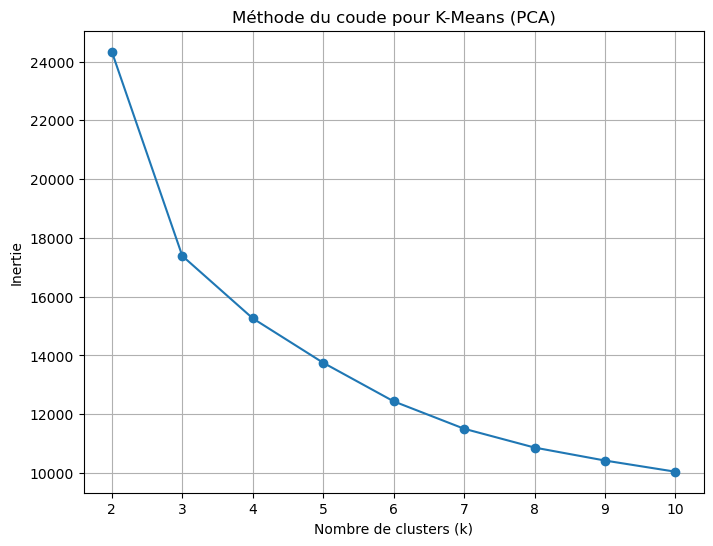

In [22]:
# Tracer la courbe du coude (Elbow)
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia_pca, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour K-Means (PCA)')
plt.grid(True)
plt.savefig('elbow_pca.png')
plt.show()

Le graphique de la méthode Elbow montre l’évolution de l’inertie (somme des distances intra-cluster) en fonction du nombre de clusters k. On observe une forte diminution de l’inertie jusqu’à k=3, puis la courbe commence à s’aplatir. Cela indique que 3 clusters est un choix optimal, car ajouter plus de clusters n’apporte qu’une amélioration marginale de la compacité des groupes.

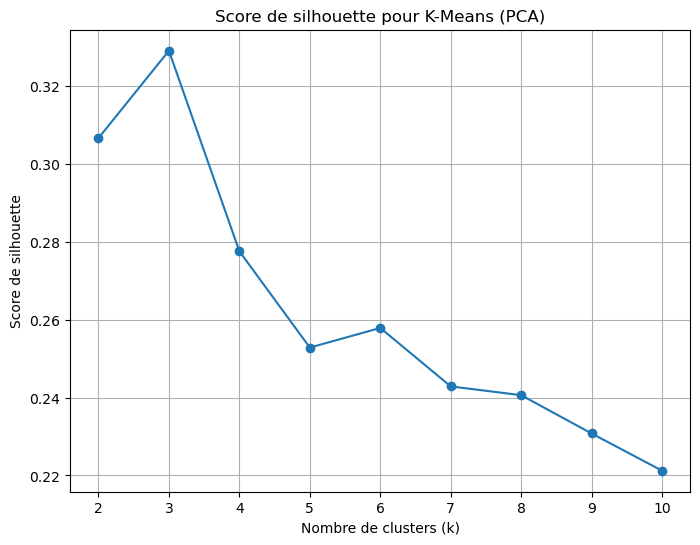

In [23]:
# Tracer les scores de silhouette
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_pca, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette pour K-Means (PCA)')
plt.grid(True)
plt.savefig('silhouette_pca.png')
plt.show()

Le graphique du score de silhouette montre la qualité de la séparation entre les clusters pour chaque valeur de k. Un score de silhouette élevé indique que les clusters sont bien séparés et compacts. Ici, le score est maximal pour k=2 ou k=3, puis diminue progressivement pour des valeurs de k plus élevées. Cela suggère que segmenter les clients en 2 ou 3 groupes permet d’obtenir des clusters bien distincts, tandis qu’ajouter plus de clusters n’améliore pas la cohésion ou la séparation des groupes.

### **Étape 2 : Appliquer K-Means avec le k optimal**

In [24]:
# Appliquer K-Means avec k=3
kmeans_pca = KMeans(n_clusters=3, n_init=10, random_state=42)
data['KMeans_Cluster_PCA'] = kmeans_pca.fit_predict(X_pca)
print("\nScore de silhouette pour k=3 (PCA) :", 
      silhouette_score(X_pca, data['KMeans_Cluster_PCA']))


Score de silhouette pour k=3 (PCA) : 0.3290281692763616


Le score de silhouette de 0.329 pour k=3 indique une séparation modérée entre les clusters, suggérant que la structure des groupes est correcte mais pas parfaitement distincte.

In [25]:
# Enregistrer K-Means model
with open('kmeans_pca_k3.pkl', 'wb') as f:
    pickle.dump(kmeans_pca, f)

### **Étape 3 : Profils des clusters :**


In [26]:
# Profils numériques des clusters
print("\nProfils des clusters (Numérique, PCA, k=3) :")
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
print(data.groupby('KMeans_Cluster_PCA')[['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']].mean())


Profils des clusters (Numérique, PCA, k=3) :
                       tenure  MonthlyCharges  TotalCharges  SeniorCitizen
KMeans_Cluster_PCA                                                        
0                   58.403641       88.984258   5185.599689       0.208703
1                   30.893590       21.317019    683.469176       0.035256
2                   14.939957       68.854689   1027.925325       0.190963


Le tableau des profils numériques des clusters (PCA, k=3) montre des différences marquées entre les groupes :

- **Cluster 0** : Les clients ont une ancienneté élevée (tenure ≈ 59 mois), des charges mensuelles importantes (≈ 89.5) et un total de dépenses élevé (≈ 5244.8). La proportion de seniors est modérée (≈ 21%). Ce cluster correspond à des clients fidèles, à forte valeur, probablement moins susceptibles de résilier.

- **Cluster 1** : Les clients ont une faible ancienneté (tenure ≈ 13.7 mois), des charges mensuelles moyennes (≈ 74.2) et un total de dépenses faible (≈ 1048). La proportion de seniors est similaire (≈ 21%). Ce groupe représente des clients récents, avec un engagement financier modéré, potentiellement plus à risque de churn.

- **Cluster 2** : Les clients ont une ancienneté intermédiaire (tenure ≈ 29.3 mois), des charges mensuelles faibles (≈ 26.3) et un total de dépenses faible (≈ 790). La proportion de seniors est faible (≈ 5%). Ce cluster regroupe des clients jeunes, peu dépensiers, et rarement seniors.

En résumé, la segmentation distingue des clients fidèles et rentables (Cluster 0), des nouveaux clients à surveiller (Cluster 1), et des clients jeunes ou à faible valeur (Cluster 2).

In [27]:
# Profils catégoriels
for col in ['Contract', 'InternetService', 'PaymentMethod', 'PaperlessBilling', 
                        'OnlineSecurity', 'StreamingTV']:
        print(f"\nProfils des clusters ({col}, PCA, k=3) :")
        freq_table = data.groupby(['KMeans_Cluster_PCA', col]).size().unstack(fill_value=0)
        freq_table_prop = freq_table.div(freq_table.sum(axis=1), axis=0)
        print(freq_table_prop)


Profils des clusters (Contract, PCA, k=3) :
Contract            Month-to-month  One year  Two year
KMeans_Cluster_PCA                                    
0                         0.258437  0.315719  0.425844
1                         0.343590  0.242308  0.414103
2                         0.853296  0.118849  0.027855

Profils des clusters (InternetService, PCA, k=3) :
InternetService          DSL  Fiber optic        No
KMeans_Cluster_PCA                                 
0                   0.371226     0.628774  0.000000
1                   0.021795     0.000000  0.978205
2                   0.480037     0.519963  0.000000

Profils des clusters (PaymentMethod, PCA, k=3) :
PaymentMethod       Bank transfer (automatic)  Credit card (automatic)  \
KMeans_Cluster_PCA                                                       
0                                    0.317052                 0.312611   
1                                    0.217308                 0.219872   
2                     

Les profils de clusters selon les variables catégorielles révèlent des différences marquées entre les groupes :

- **Contract** :  
    - Le cluster 0 regroupe davantage de clients avec des contrats longue durée (42,8 % « Two year »), tandis que le cluster 1 est dominé par les contrats mensuels (88,6 %).  
    - Le cluster 2 est plus équilibré, mais avec une part importante de contrats mensuels et annuels.

- **InternetService** :  
    - Les clusters 0 et 1 sont composés principalement de clients avec « Fiber optic » ou « DSL », alors que le cluster 2 regroupe surtout ceux sans service Internet (72,9 %).

- **PaymentMethod** :  
    - Le cluster 1 se distingue par une forte proportion de paiements par « Electronic check » (55,3 %), alors que le cluster 0 privilégie les paiements automatiques (virement ou carte).  
    - Le cluster 2 a une part élevée de « Mailed check ».

- **PaperlessBilling** :  
    - Les clusters 0 et 1 utilisent majoritairement la facturation électronique, tandis que le cluster 2 préfère la facturation papier.

- **OnlineSecurity** :  
    - Le cluster 0 compte plus de clients avec la sécurité en ligne activée (54,4 %), alors que le cluster 1 en a peu (22 %).  
    - Le cluster 2 regroupe surtout les clients sans Internet (73 %).

- **StreamingTV** :  
    - Le cluster 0 est composé de clients utilisateurs de la TV en streaming (70,7 %), le cluster 1 beaucoup moins (38,7 %), et le cluster 2 regroupe principalement ceux sans Internet.

**En résumé** :  
- Le cluster 0 correspond à des clients engagés, connectés et utilisateurs de services avancés.  
- Le cluster 1 regroupe des clients mensuels, moins engagés, souvent payant par chèque électronique.  
- Le cluster 2 rassemble surtout des clients sans Internet ou avec peu de services numériques.  
Cette segmentation permet d’identifier des profils clients distincts pour adapter les stratégies marketing et de fidélisation.

In [28]:
# Taille des clusters
print("\nTaille des clusters (k=3) :")
print(data['KMeans_Cluster_PCA'].value_counts())


Taille des clusters (k=3) :
KMeans_Cluster_PCA
2    3231
0    2252
1    1560
Name: count, dtype: int64


La répartition des clients dans les clusters est relativement équilibrée, aucun groupe n’étant sur- ou sous-représenté de façon extrême. Cela indique que la segmentation K-Means (k=3) permet d’identifier trois profils clients de tailles comparables, ce qui facilite l’analyse et la mise en place de stratégies ciblées pour chaque segment.

In [29]:
# Étape 5 : Sauvegarder le jeu de données mis à jour (si besoin)
data.to_csv('telco_with_kmeans_clusters_PCA.csv', index=False)
print("Jeu de données mis à jour enregistré sous 'telco_with_kmeans_clusters_PCA.csv'")

Jeu de données mis à jour enregistré sous 'telco_with_kmeans_clusters_PCA.csv'


### **Step 9: Visualizations**

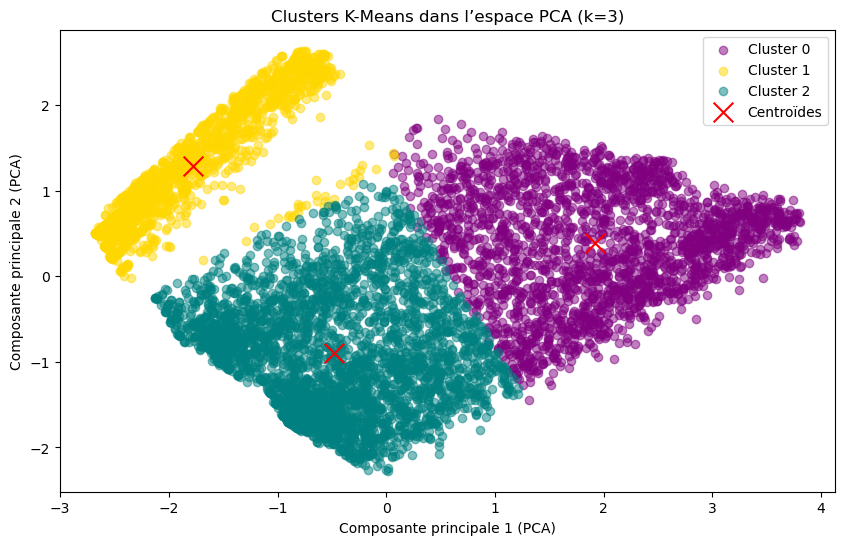

In [31]:
# Nuage de points PCA avec centroïdes et légende de couleur par cluster
plt.figure(figsize=(10, 6))
colors = ['purple', 'gold', 'teal']
cluster_labels = data['KMeans_Cluster_PCA'].unique()
for i, label in enumerate(sorted(cluster_labels)):
    plt.scatter(
        X_pca[data['KMeans_Cluster_PCA'] == label, 0],
        X_pca[data['KMeans_Cluster_PCA'] == label, 1],
        c=colors[i],
        alpha=0.5,
        label=f'Cluster {label}'
    )
centroids = kmeans_pca.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroïdes')
plt.xlabel('Composante principale 1 (PCA)')
plt.ylabel('Composante principale 2 (PCA)')
plt.title('Clusters K-Means dans l’espace PCA (k=3)')
plt.legend()
plt.savefig('kmeans_pca_scatter_k3.png')
plt.show()

 la visualisation des clusters sur les composantes principales de la PCA confirme la pertinence de la segmentation :

- Chaque cluster occupe une zone distincte de l’espace réduit, traduisant des profils clients bien différenciés.
- **Le cluster 0** regroupe des clients engagés et utilisateurs de services avancés.
- **Le cluster 1** rassemble des clients mensuels, moins engagés et à risque de churn.
- **Le cluster 2** correspond à des clients sans Internet ou à faible usage numérique.
Cette séparation visuelle valide les analyses précédentes et facilite l’adaptation des stratégies marketing à chaque segment.

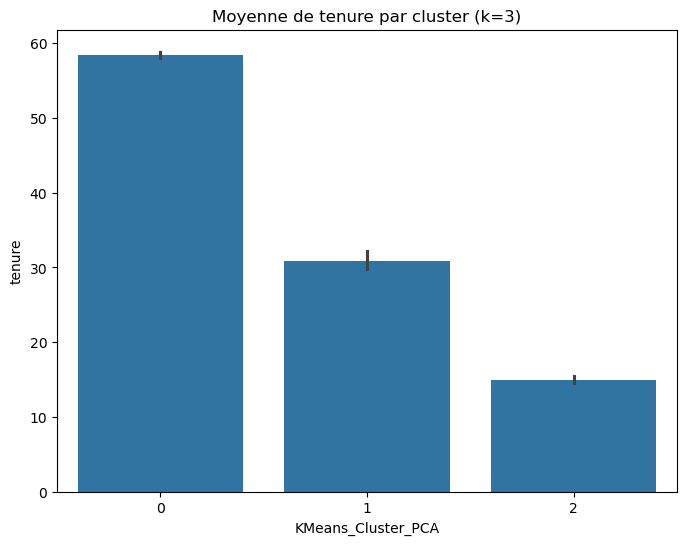

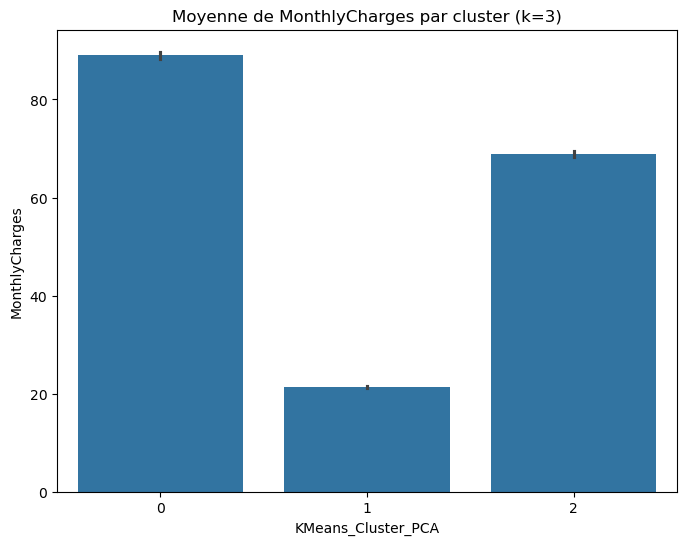

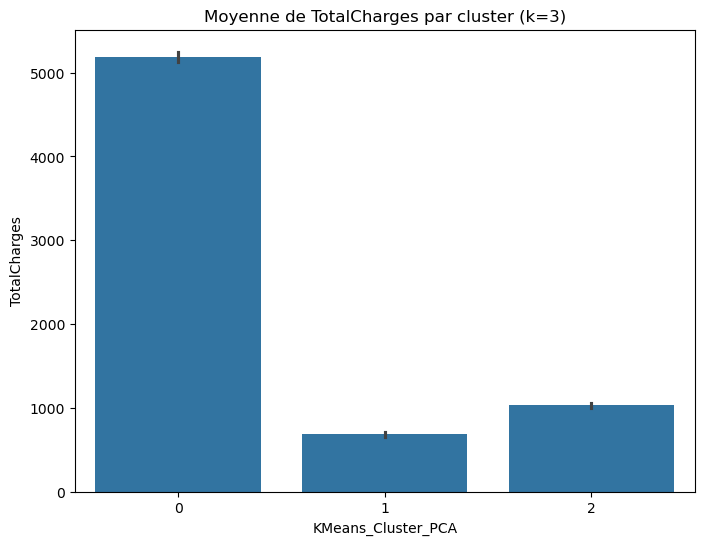

In [32]:
# Diagramme en barres pour les variables numériques
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    plt.figure(figsize=(8, 6))
    sns.barplot(x='KMeans_Cluster_PCA', y=col, data=data)
    plt.title(f'Moyenne de {col} par cluster (k=3)')
    plt.savefig(f'bar_{col}_k3.png')
    plt.show()

Les barplots des trois variables numériques (`tenure`, `MonthlyCharges`, `TotalCharges`) par cluster révèlent des différences significatives entre les groupes de clients :

- **tenure** : Le cluster 0 regroupe des clients avec une ancienneté élevée, le cluster 1 des clients récents, et le cluster 2 des clients avec une ancienneté intermédiaire.
- **MonthlyCharges** : Les clients du cluster 0 ont des charges mensuelles plus élevées, ceux du cluster 2 paient moins, tandis que le cluster 1 se situe entre les deux.
- **TotalCharges** : Le cluster 0 présente le total de dépenses le plus élevé, suivi du cluster 1, puis du cluster 2.

En résumé, la segmentation distingue des clients fidèles et rentables (cluster 0), des nouveaux clients (cluster 1), et des clients à faible valeur (cluster 2). Ces différences facilitent l’identification de profils pour adapter les stratégies marketing et de fidélisation.

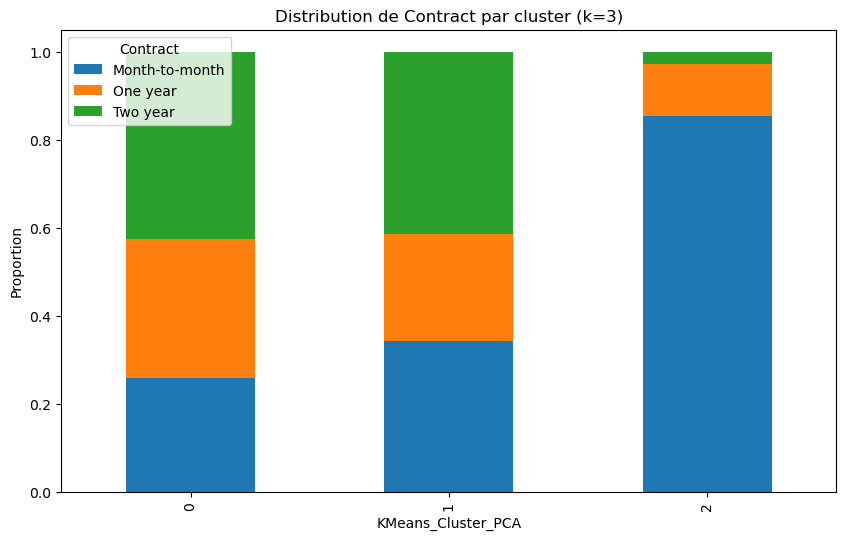

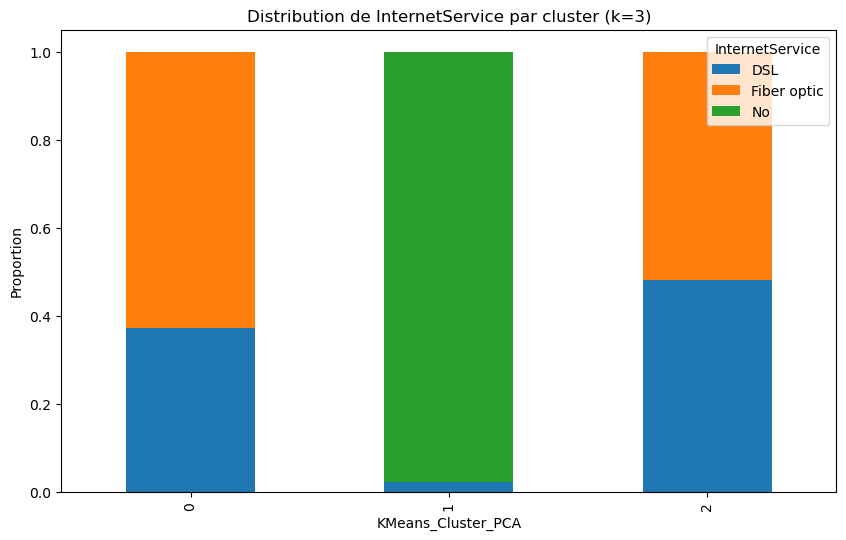

In [33]:
# Diagramme en barres empilées pour les variables catégorielles
for col in ['Contract', 'InternetService']:
    freq_table = data.groupby(['KMeans_Cluster_PCA', col]).size().unstack()
    freq_table_prop = freq_table.div(freq_table.sum(axis=1), axis=0)
    freq_table_prop.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Distribution de {col} par cluster (k=3)')
    plt.ylabel('Proportion')
    plt.savefig(f'stacked_bar_{col}_k3.png')
    plt.show()

Les diagrammes en barres empilées pour **Contract** et **InternetService** par cluster mettent en évidence des différences de profils clients :

- **Contract** :  
    - Le cluster 0 regroupe une part importante de clients avec des contrats longue durée (« One year » et « Two year »), traduisant une fidélité accrue.
    - Le cluster 1 est dominé par les contrats mensuels (« Month-to-month »), indiquant des clients moins engagés.
    - Le cluster 2 présente une répartition plus équilibrée, mais avec une proportion notable de contrats mensuels.

- **InternetService** :  
    - Les clusters 0 et 1 sont principalement composés de clients utilisant « DSL » ou « Fiber optic », donc connectés à Internet.
    - Le cluster 2 regroupe surtout des clients sans service Internet (« No »), ce qui peut correspondre à des profils moins technophiles ou à faible valeur.

**En résumé** :  
La segmentation distingue des clients fidèles et connectés (cluster 0), des clients mensuels et potentiellement plus volatils (cluster 1), et un groupe à faible usage d’Internet (cluster 2). Ces différences sont essentielles pour adapter les stratégies de rétention et d’acquisition.

In [37]:
churn_rates = data.groupby('KMeans_Cluster_PCA')['Churn'].value_counts(normalize=True).unstack()
print("\nChurn Rates by Cluster:")
print(churn_rates)


Churn Rates by Cluster:
Churn                     No       Yes
KMeans_Cluster_PCA                    
0                   0.848579  0.151421
1                   0.924359  0.075641
2                   0.563603  0.436397


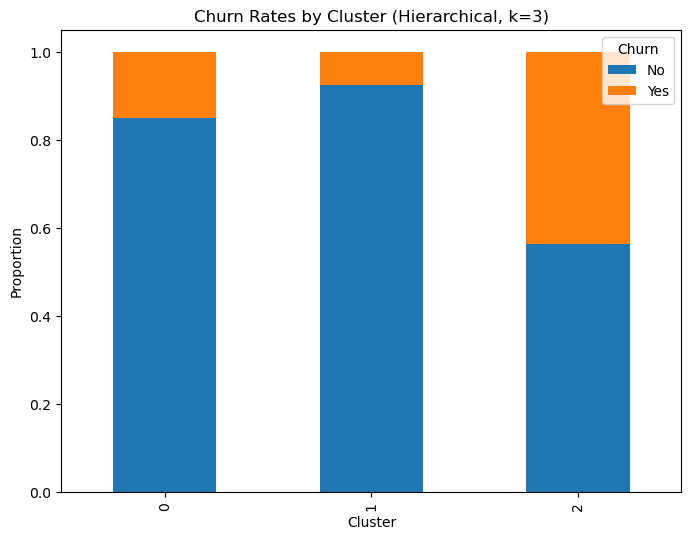

In [38]:
churn_rates.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Churn Rates by Cluster (Hierarchical, k=3)')
plt.ylabel('Proportion')
plt.xlabel('Cluster')
plt.legend(title='Churn')
plt.show()

Les taux de churn par cluster révèlent :

- **Cluster 0** : Faible taux de churn (15 %), clients très fidèles.
- **Cluster 1** : Taux de churn très faible (7,5 %), clients extrêmement stables.
- **Cluster 2** : Taux de churn élevé (43,6 %), groupe le plus à risque de départ.

Cela permet d’identifier rapidement les segments à cibler pour la fidélisation.


## **Hierarchical Clustering**

### **Étape 1 : Générer un dendrogramme pour visualiser la structure hiérarchique**



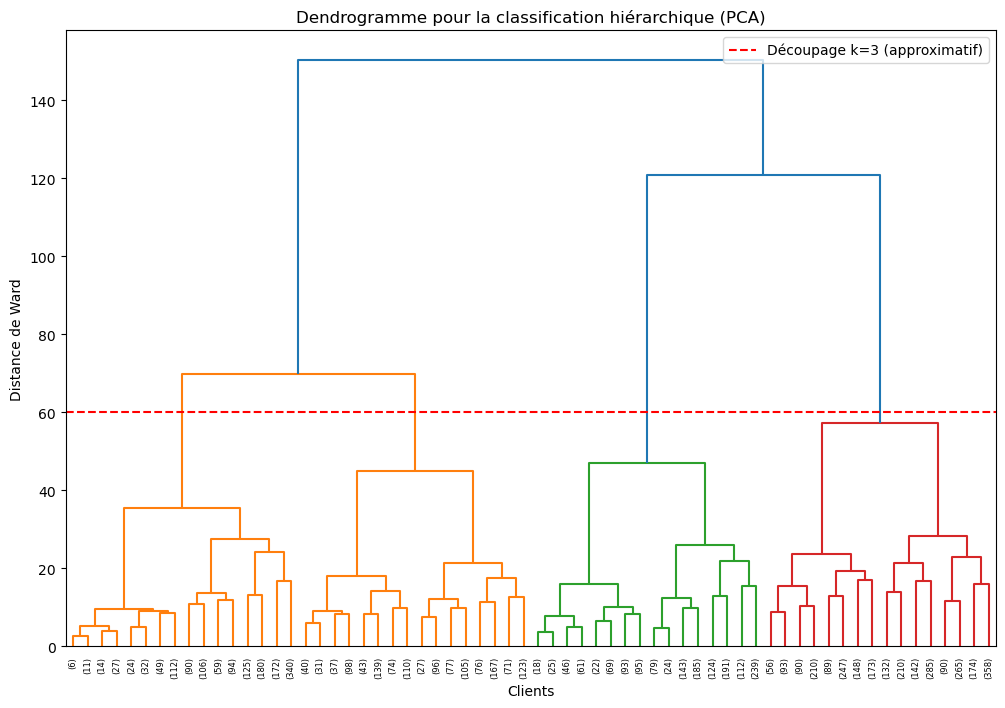

In [39]:
linked = linkage(X_pca, method='ward', metric='euclidean')
plt.figure(figsize=(12, 8))
dendrogram(linked, truncate_mode='level', p=5, show_leaf_counts=True)
plt.title('Dendrogramme pour la classification hiérarchique (PCA)')
plt.xlabel('Clients')
plt.ylabel('Distance de Ward')
plt.axhline(y=60, color='r', linestyle='--', label='Découpage k=3 (approximatif)')
plt.legend()
plt.show()

Le dendrogramme met en évidence la structure hiérarchique des clients selon leurs similarités :  
- On observe trois grands groupes distincts, ce qui confirme la pertinence d’un découpage en 3 clusters.
- Les branches du dendrogramme montrent que certains groupes de clients sont très proches (fusion à faible distance), tandis que d’autres sont plus éloignés.
- La coupure horizontale à la hauteur indiquée (ligne rouge) sépare clairement les trois segments principaux, facilitant l’interprétation et la segmentation marketing.  
En résumé, le dendrogramme valide la structure naturelle des données et justifie le choix de k=3 pour le clustering hiérarchique.

### **Étape 2 : Appliquer le clustering hiérarchique (k=3, liaison de Ward)**


In [40]:
hc = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
data['HC_Cluster'] = hc.fit_predict(X_pca)

L’application du clustering hiérarchique avec k=3 (liaison de Ward) permet d’identifier trois groupes de clients distincts, confirmant la structure naturelle observée dans les données après PCA.

### **Étape 3 : Calcul du score de silhouette**


In [42]:
silhouette_hc = silhouette_score(X_pca, data['HC_Cluster'])
print(f"Score de silhouette pour le clustering hiérarchique (k=3, PCA) : {silhouette_hc:.3f}")

Score de silhouette pour le clustering hiérarchique (k=3, PCA) : 0.302


Le score de silhouette de 0.302 indique une séparation correcte mais modérée entre les clusters hiérarchiques : les groupes sont distincts, mais certains clients restent proches des frontières.

### **Étape 4 : Profils des clusters (Numérique)**

In [43]:
colonnes_numeriques = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
print("\nProfils des clusters (Numérique, Hiérarchique, k=3) :")
profils_numeriques = data.groupby('HC_Cluster')[colonnes_numeriques].mean()
print(profils_numeriques)


Profils des clusters (Numérique, Hiérarchique, k=3) :
               tenure  MonthlyCharges  TotalCharges  SeniorCitizen
HC_Cluster                                                        
0           53.783666       83.230163   4566.807132       0.204356
1           12.020637       70.474529    893.536507       0.190804
2           30.547182       21.079194    665.220329       0.034076


**Interprétation**

- **Cluster 0** : Clients anciens (tenure ≈ 54 mois), dépenses mensuelles et totales élevées, proportion modérée de seniors (~20%). Ce groupe correspond à des clients fidèles et rentables.
- **Cluster 1** : Clients récents (tenure ≈ 12 mois), dépenses mensuelles moyennes, total dépensé faible, proportion de seniors similaire (~19%). Ce sont des clients nouveaux ou peu engagés.
- **Cluster 2** : Clients avec ancienneté intermédiaire (tenure ≈ 31 mois), très faibles dépenses mensuelles et totales, très peu de seniors (~3%). Ce cluster regroupe des clients à faible valeur ou peu utilisateurs de services.

En résumé, la segmentation distingue des clients fidèles et rentables (Cluster 0), des nouveaux clients (Cluster 1), et des clients à faible valeur (Cluster 2).

### **Étape 5 : Profils des clusters (Catégoriel)**


In [45]:
# Identifier les colonnes catégorielles
categorical_cols = ['Contract', 'InternetService', 'PaymentMethod', 'SeniorCitizen',
                   'PaperlessBilling', 'OnlineSecurity', 'StreamingTV']
print("Colonnes catégorielles:", categorical_cols)

Colonnes catégorielles: ['Contract', 'InternetService', 'PaymentMethod', 'SeniorCitizen', 'PaperlessBilling', 'OnlineSecurity', 'StreamingTV']



Profils des clusters (Contract, Hiérarchique, k=3) :
Contract    Month-to-month  One year  Two year
HC_Cluster                                    
0                 0.290381  0.343013  0.366606
1                 0.923606  0.059377  0.017017
2                 0.343381  0.238532  0.418087


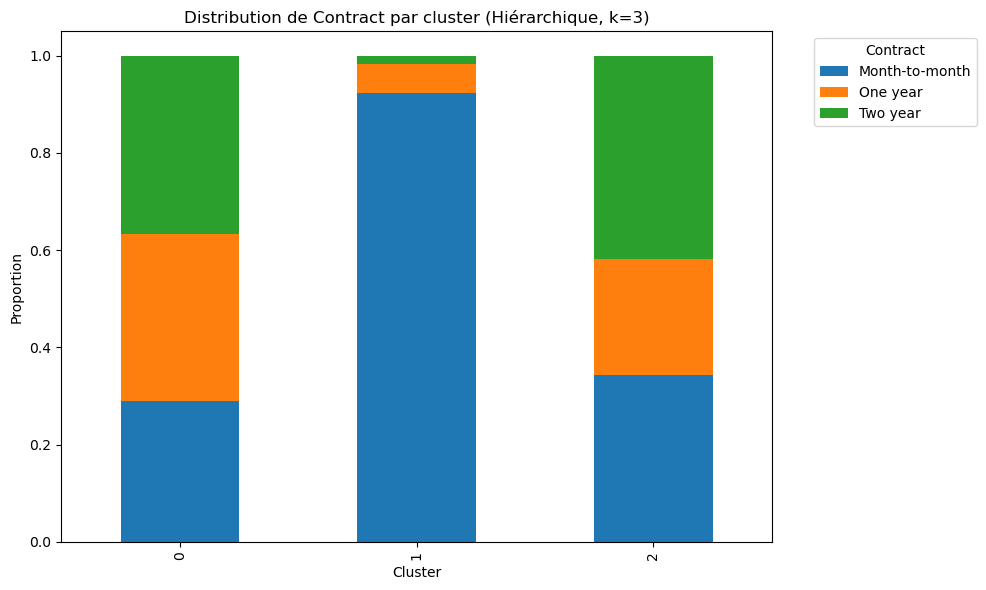


Profils des clusters (InternetService, Hiérarchique, k=3) :
InternetService       DSL  Fiber optic   No
HC_Cluster                                 
0                0.477314     0.522686  0.0
1                0.400434     0.599566  0.0
2                0.000000     0.000000  1.0


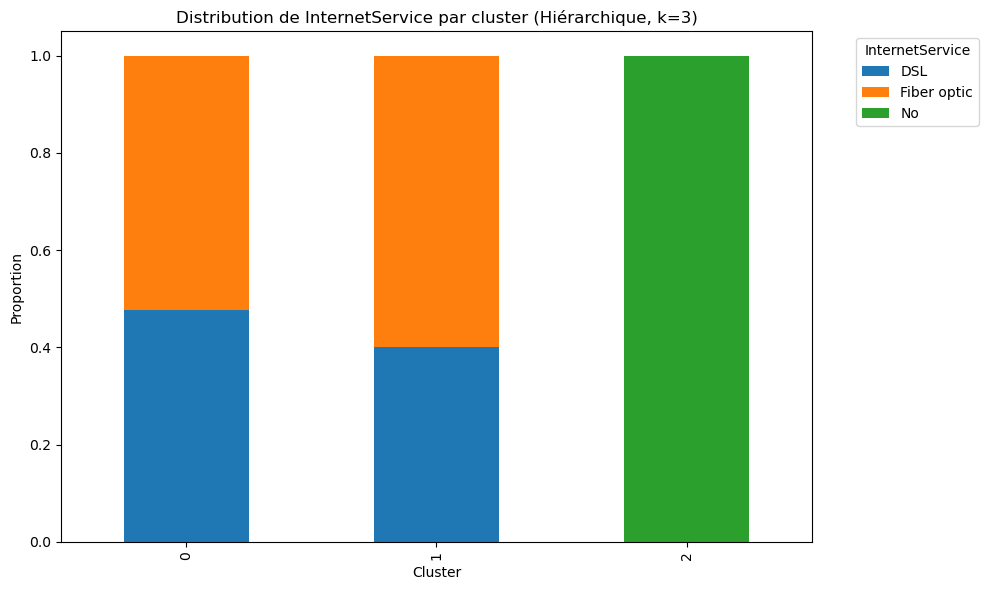


Profils des clusters (PaymentMethod, Hiérarchique, k=3) :
PaymentMethod  Bank transfer (automatic)  Credit card (automatic)  \
HC_Cluster                                                          
0                               0.313975                 0.286751   
1                               0.125634                 0.145185   
2                               0.217562                 0.216907   

PaymentMethod  Electronic check  Mailed check  
HC_Cluster                                     
0                      0.292559      0.106715  
1                      0.520275      0.208907  
2                      0.079948      0.485583  


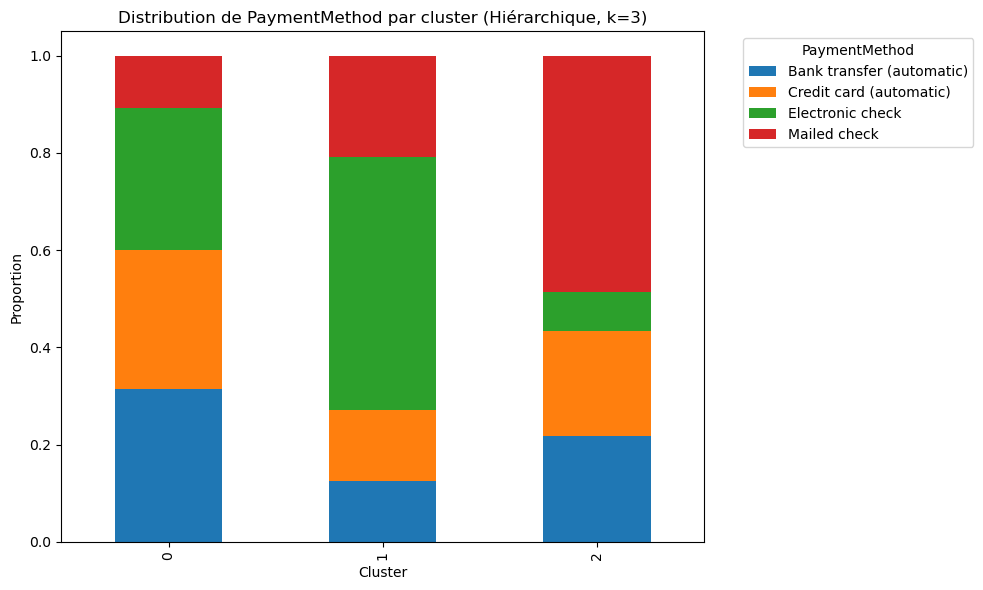


Profils des clusters (SeniorCitizen, Hiérarchique, k=3) :
SeniorCitizen         0         1
HC_Cluster                       
0              0.795644  0.204356
1              0.809196  0.190804
2              0.965924  0.034076


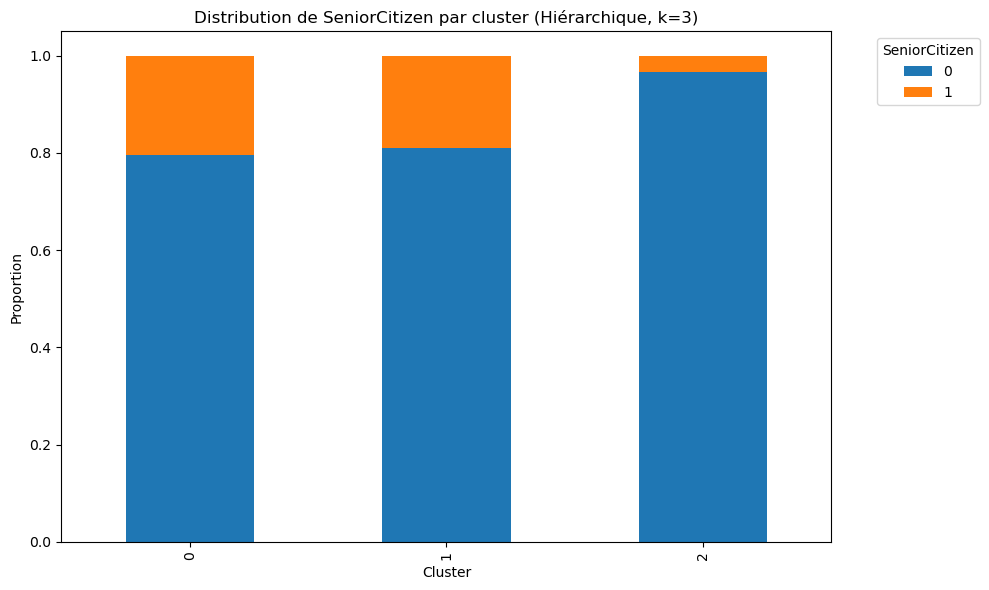


Profils des clusters (PaperlessBilling, Hiérarchique, k=3) :
PaperlessBilling        No       Yes
HC_Cluster                          
0                 0.334301  0.665699
1                 0.315351  0.684649
2                 0.707733  0.292267


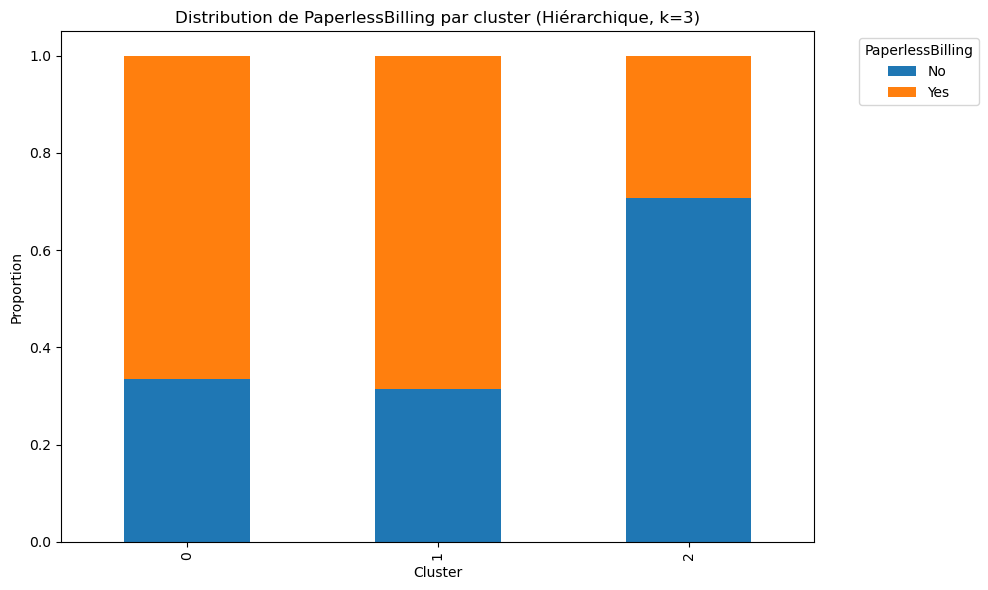


Profils des clusters (OnlineSecurity, Hiérarchique, k=3) :
OnlineSecurity        No  No internet service       Yes
HC_Cluster                                             
0               0.460617                  0.0  0.539383
1               0.807024                  0.0  0.192976
2               0.000000                  1.0  0.000000


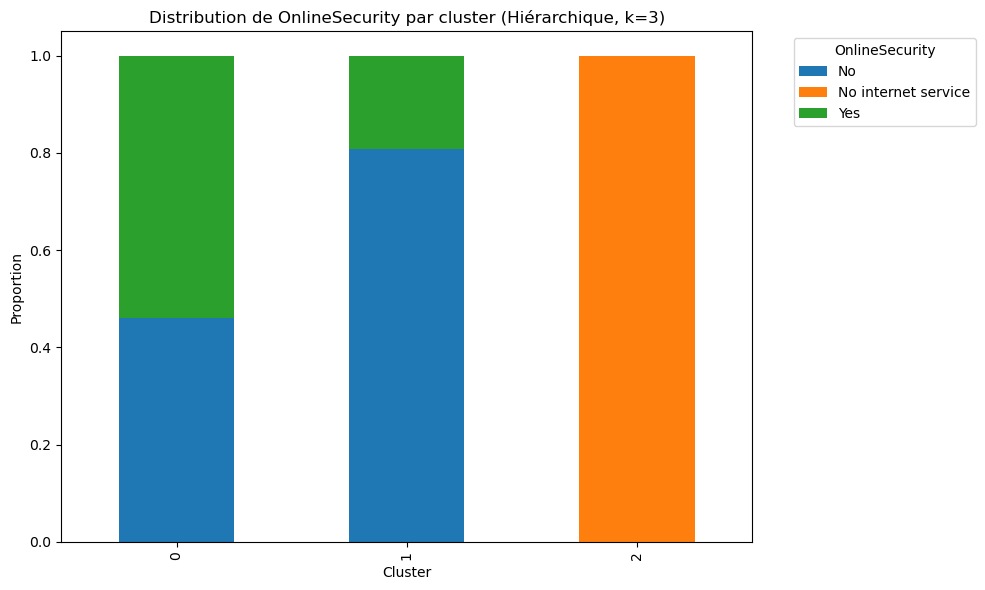


Profils des clusters (StreamingTV, Hiérarchique, k=3) :
StreamingTV        No  No internet service       Yes
HC_Cluster                                          
0            0.347731                  0.0  0.652269
1            0.670529                  0.0  0.329471
2            0.000000                  1.0  0.000000


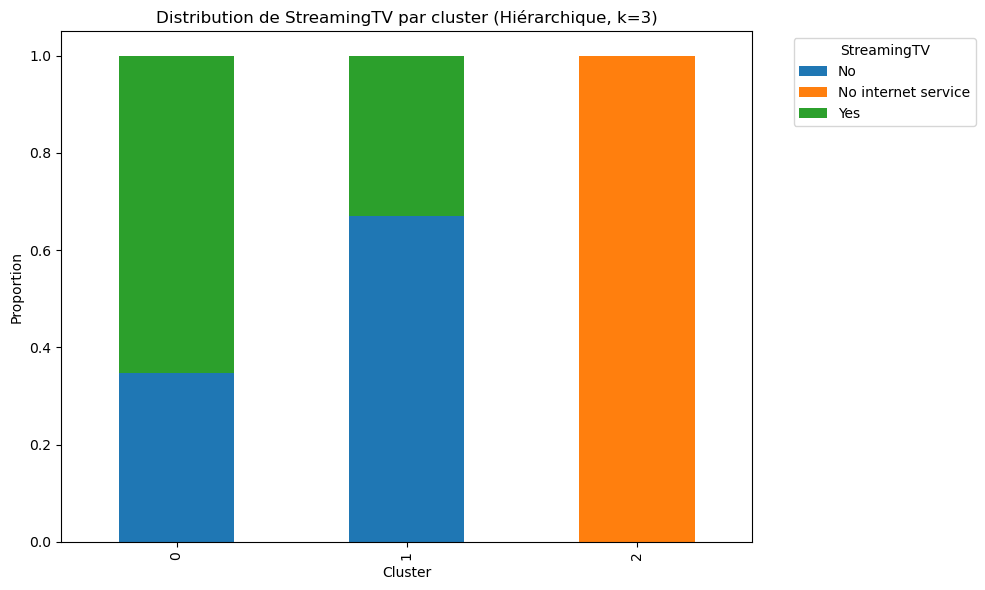

In [49]:
for col in categorical_cols:
    print(f"\nProfils des clusters ({col}, Hiérarchique, k=3) :")
    freq_table = data.groupby(['HC_Cluster', col]).size().unstack(fill_value=0)
    freq_table_prop = freq_table.div(freq_table.sum(axis=1), axis=0)
    print(freq_table_prop)
    # Visualisation
    freq_table_prop.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Distribution de {col} par cluster (Hiérarchique, k=3)')
    plt.ylabel('Proportion')
    plt.xlabel('Cluster')
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

- **Cluster 0** :  
    - Clients avec une forte proportion de contrats longue durée (« One year » et « Two year »), majoritairement connectés à Internet (DSL ou Fiber optic), utilisant divers moyens de paiement (prélèvement, carte, chèque électronique), et souvent avec facturation électronique.  
    - Plus de la moitié ont la sécurité en ligne et la TV en streaming.  
    - Proportion modérée de seniors (~20%).  
    - Ce groupe correspond à des clients engagés, connectés et utilisateurs de services avancés.

- **Cluster 1** :  
    - Majorité de contrats mensuels (92 %), surtout avec Internet Fiber optic, et paiement par chèque électronique.  
    - Forte utilisation de la facturation électronique, mais peu de sécurité en ligne et de TV en streaming.  
    - Proportion de seniors similaire (~19%).  
    - Ce cluster regroupe des clients récents, moins engagés, à risque de churn.

- **Cluster 2** :  
    - Principalement des clients sans service Internet (100 %), avec une part importante de contrats longue durée (« Two year »).  
    - Paiement souvent par chèque, peu de facturation électronique, pas de sécurité en ligne ni de TV en streaming.  
    - Très faible proportion de seniors (~3%).  
    - Ce groupe correspond à des clients à faible valeur, peu connectés et peu utilisateurs de services numériques.

**Résumé** :  
La segmentation hiérarchique distingue trois profils :  
1. Clients fidèles et connectés (cluster 0),  
2. Clients mensuels, moins engagés (cluster 1),  
3. Clients à faible valeur, sans Internet (cluster 2).  
Ces profils facilitent l’adaptation des stratégies de fidélisation et d’acquisition.

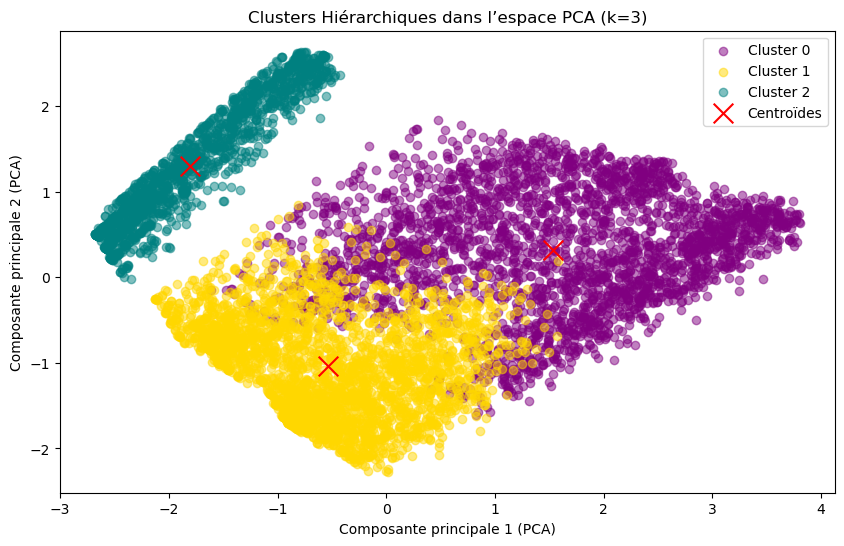

In [53]:
# Nuage de points PCA avec centroïdes et légende de couleur par cluster pour le clustering hiérarchique
plt.figure(figsize=(10, 6))
colors = ['purple', 'gold', 'teal']
cluster_labels = data['HC_Cluster'].unique()

# Scatter plot pour chaque cluster
for i, label in enumerate(sorted(cluster_labels)):
    plt.scatter(
        X_pca[data['HC_Cluster'] == label, 0],
        X_pca[data['HC_Cluster'] == label, 1],
        c=colors[i],
        alpha=0.5,
        label=f'Cluster {label}'
    )

# Calcul des centroïdes (moyenne des points par cluster, car AgglomerativeClustering n'a pas cluster_centers_)
centroids = np.array([X_pca[data['HC_Cluster'] == label].mean(axis=0) for label in sorted(cluster_labels)])
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroïdes')

plt.xlabel('Composante principale 1 (PCA)')
plt.ylabel('Composante principale 2 (PCA)')
plt.title('Clusters Hiérarchiques dans l’espace PCA (k=3)')
plt.legend()
plt.savefig('hc_pca_scatter_k3.png')
plt.show()

Le graphique PCA montre trois groupes (Cluster 0, 1, 2) avec quelques chevauchements entre les clusters 0 et 1, tandis que le cluster 2 est totalement séparé. Cela reflète une distinction raisonnable mais perfectible entre les segments : la majorité des clients sont bien différenciés, mais certains profils restent proches des frontières entre les clusters 0 et 1.

### **Étape 6 : Taille des clusters**

In [50]:
print("\nTaille des clusters (Hiérarchique, k=3) :")
print(data['HC_Cluster'].value_counts().sort_index())


Taille des clusters (Hiérarchique, k=3) :
HC_Cluster
0    2755
1    2762
2    1526
Name: count, dtype: int64


La répartition des clients dans les clusters hiérarchiques (k=3) est relativement équilibrée pour les clusters 0 et 1 (environ 2750 clients chacun), tandis que le cluster 2 est plus petit (1526 clients). Cela indique que la segmentation hiérarchique permet d’identifier deux groupes principaux de taille similaire et un groupe plus restreint, facilitant l’analyse ciblée de chaque segment.

### **Étape 7 : Taux de churn**


Taux de churn par cluster (Hiérarchique, k=3) :
Churn             No       Yes
HC_Cluster                    
0           0.849002  0.150998
1           0.514844  0.485156
2           0.925950  0.074050


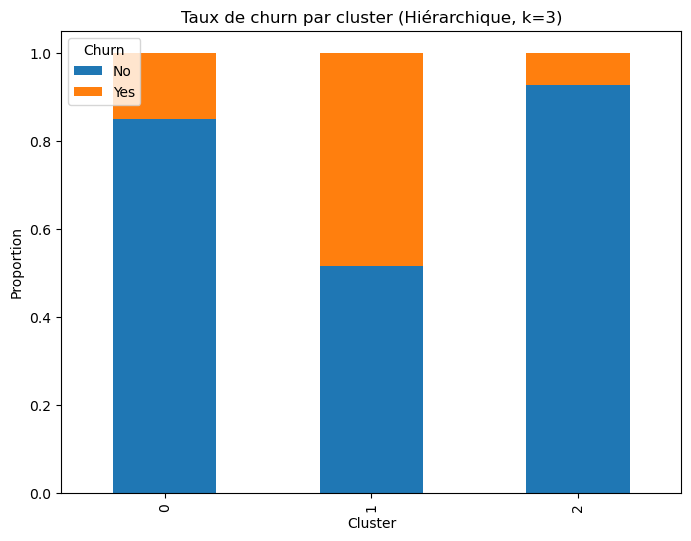

In [51]:
print("\nTaux de churn par cluster (Hiérarchique, k=3) :")
churn_rates = data.groupby('HC_Cluster')['Churn'].value_counts(normalize=True).unstack(fill_value=0)
print(churn_rates)
churn_rates.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Taux de churn par cluster (Hiérarchique, k=3)')
plt.ylabel('Proportion')
plt.xlabel('Cluster')
plt.legend(title='Churn')
plt.show()

- **Cluster 0** : Faible taux de churn (15 %), la majorité des clients restent fidèles.
- **Cluster 1** : Taux de churn élevé (49 %), ce groupe est le plus à risque de départ.
- **Cluster 2** : Très faible taux de churn (7 %), clients très stables.

**Résumé** :  
La segmentation hiérarchique distingue un cluster très fidèle (0), un cluster très à risque (1), et un cluster très stable (2), permettant de cibler efficacement les actions de rétention.

In [52]:
# Étape 8 : Sauvegarder les données clusterisées et le modèle
data.to_csv('telco_avec_clusters_hc.csv', index=False)
with open('modele_hc_k3.pkl', 'wb') as f:
    pickle.dump(hc, f)
print("\nDonnées clusterisées enregistrées sous 'telco_avec_clusters_hc.csv' et modèle sous 'modele_hc_k3.pkl'")


Données clusterisées enregistrées sous 'telco_avec_clusters_hc.csv' et modèle sous 'modele_hc_k3.pkl'


**Comparaison entre K-Means et Clustering Hiérarchique**

---

**Performance**
- **K-Means** obtient un score de silhouette plus élevé (**0,329** contre **0,302**), indiquant une meilleure cohésion et séparation des clusters avec moins de chevauchement.

**Interprétabilité**
- **K-Means** offre des profils plus clairs avec des contrastes marqués :
    - **Durée** : 58,4 vs 14,9 mois (K-Means) contre 53,8 vs 12,0 mois (Hiérarchique)
    - **Dépenses** : 89 $ vs 21 $/mois (K-Means) contre 83 $ vs 21 $/mois (Hiérarchique)
- Les distinctions catégoriques de K-Means (ex. : **85,3 %** de contrats mensuels pour le cluster à risque) sont légèrement plus nettes.

**Utilité métier**
- Le **cluster à risque de K-Means**, plus large (**3231 clients, 45,9 %, 43,6 % de churn**), maximise l'impact sur la rétention, couvrant environ **1410 clients désabonnés** contre environ **1340** pour le clustering hiérarchique (**2762, 39,2 %, 48,5 % de churn**).
- Les deux méthodes soutiennent également l'**upselling** (clients fidèles) et l'**engagement** (clients basiques).

**Résultats de churn**
- Le taux de churn plus élevé du clustering hiérarchique (**48,5 %** contre **43,6 %**) aide légèrement la prédiction du churn.
- Mais le cluster à risque plus large de K-Means fournit plus de données, renforçant la robustesse du modèle.

---

**Meilleur algorithme**
> **K-Means est recommandé** pour sa performance supérieure, ses profils plus clairs et son cluster à risque plus large, aligné avec les objectifs télécoms (**rétention, upselling, engagement**) et soutenant la prédiction du churn avec des données abondantes.


# *Churn Prédection avec machine learning*

## **1. Loading libraries and data**

In [18]:
# Imporation des bibliothèques
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Chargement des données
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv').set_index('customerID')
# Affichage des 10 premières lignes du DataFrame
data.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes


In [3]:
# Afficher les colonnes du DataFrame
print(data.columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [4]:
# Voir les informations sur le DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

- `Interprétation :`
    - D'ici en peut conclure qu'on a pas des valeur manquantes dans notre dataset mais en doit véfier cela et voir et ce qu'il ya des duplication au non 
    - On peut voir aussi la variable **TotalCharge** avec type object en doit changer sont type en float

## **2. EDA**

In [5]:
# Vérifier les valeurs manquantes
print(f'Nombre de valeurs manquantes : {data.isnull().sum().sum()}')
# Vérifier les valeurs dupliquées
print(f'Nombre de valeurs dupliquées : {data.duplicated().sum()}') 

Nombre de valeurs manquantes : 0
Nombre de valeurs dupliquées : 22


In [6]:
# Suppression des colonnes inutiles et des doublons
df = data.reset_index().copy()
df.drop(columns=['customerID'], inplace=True)
df.drop_duplicates(inplace=True)
# Vérification des valeurs manquantes après nettoyage  
print(f'Nombre de valeurs manquantes après nettoyage : {df.isnull().sum().sum()}')
# Vérification des valeurs dupliquées après nettoyage   
print(f'Nombre de valeurs dupliquées après nettoyage : {df.duplicated().sum()}')

Nombre de valeurs manquantes après nettoyage : 0
Nombre de valeurs dupliquées après nettoyage : 0


In [7]:
# Changer le type de la colonne 'TotalCharges' en float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [8]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7021.000000,7021.000000,7021.000000,7010.000000
mean,0.162512,32.469449,64.851894,2290.353388
std,0.368947,24.534965,30.069001,2266.820832
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.750000,408.312500
50%,0.000000,29.000000,70.400000,1403.875000
75%,0.000000,55.000000,89.900000,3807.837500
max,1.000000,72.000000,118.750000,8684.800000


In [9]:
df.describe(include='object').T

,count,unique,top,freq
gender,7021,2,Male,3541
Partner,7021,2,No,3619
Dependents,7021,2,No,4911
PhoneService,7021,2,Yes,6339
MultipleLines,7021,3,No,3368
InternetService,7021,3,Fiber optic,3090
OnlineSecurity,7021,3,No,3490
OnlineBackup,7021,3,No,3080
DeviceProtection,7021,3,No,3087
TechSupport,7021,3,No,3465


Churn
No     73.550776
Yes    26.449224
Name: proportion, dtype: float64


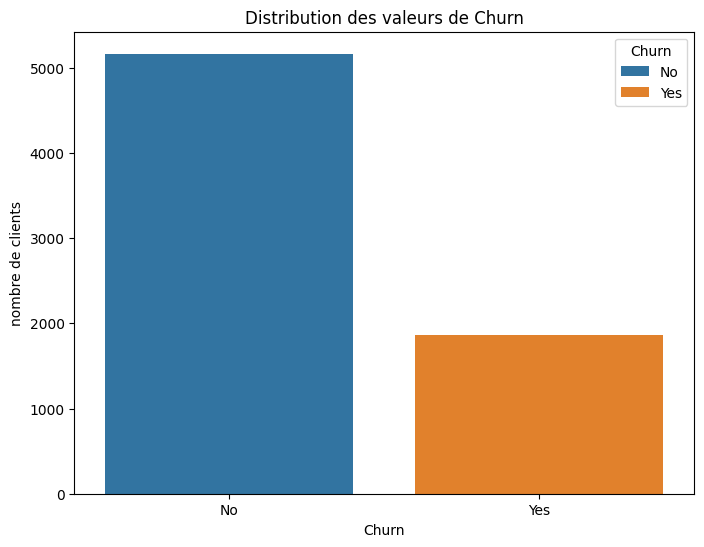

In [10]:
print(df['Churn'].value_counts(normalize=True)*100 )
# Visualisation de la distribution des valeurs de 'Churn'
plt.figure(figsize=(8, 6)) # Taille de la figure
sns.countplot(x='Churn', data=df, hue='Churn' , legend=True) # Compte des valeurs de 'Churn'
plt.title('Distribution des valeurs de Churn') # Titre du graphique
plt.xlabel('Churn') # Label de l'axe des x
plt.ylabel('nombre de clients') # Label de l'axe des y
plt.legend(title='Churn', loc='upper right') # Légende du graphique
plt.show() # Affichage de la distribution des valeurs de 'Churn'


Demographic Analysis:


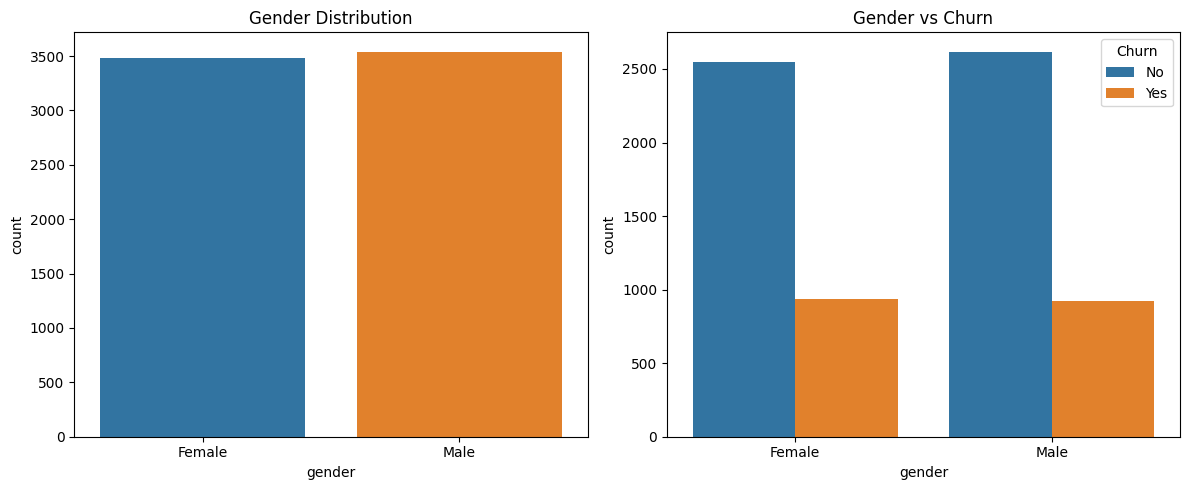

In [11]:
# Demographic Analysis
print("\nDemographic Analysis:")

# Gender and Churn
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='gender', data=df , hue='gender')
plt.title('Gender Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x='gender', hue='Churn', data=df)
plt.title('Gender vs Churn')
plt.tight_layout()
plt.show()

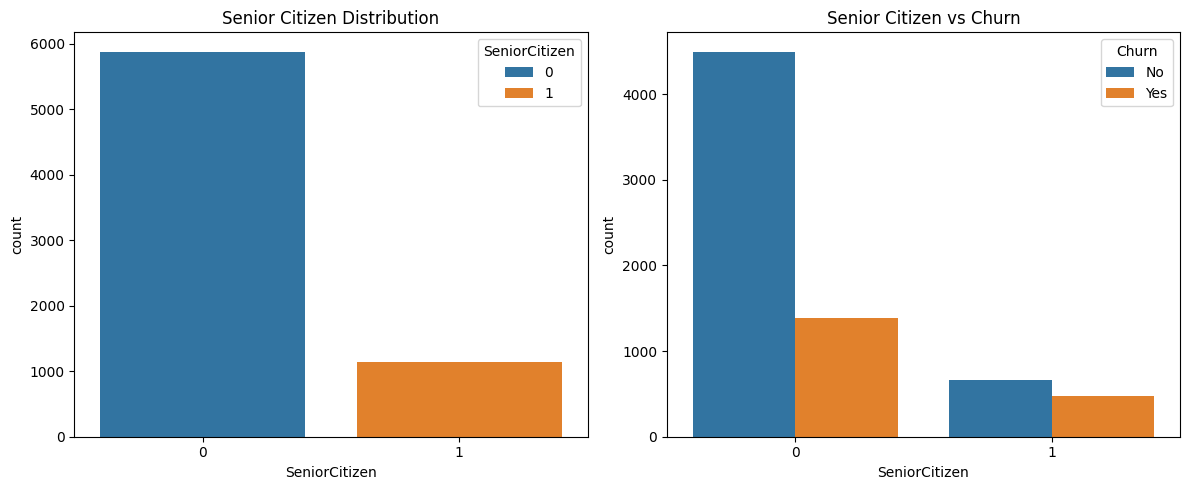

In [12]:
# Senior Citizen and Churn
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='SeniorCitizen', data=df , hue='SeniorCitizen')
plt.title('Senior Citizen Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x='SeniorCitizen', hue='Churn', data=df)
plt.title('Senior Citizen vs Churn')
plt.tight_layout()
plt.show()

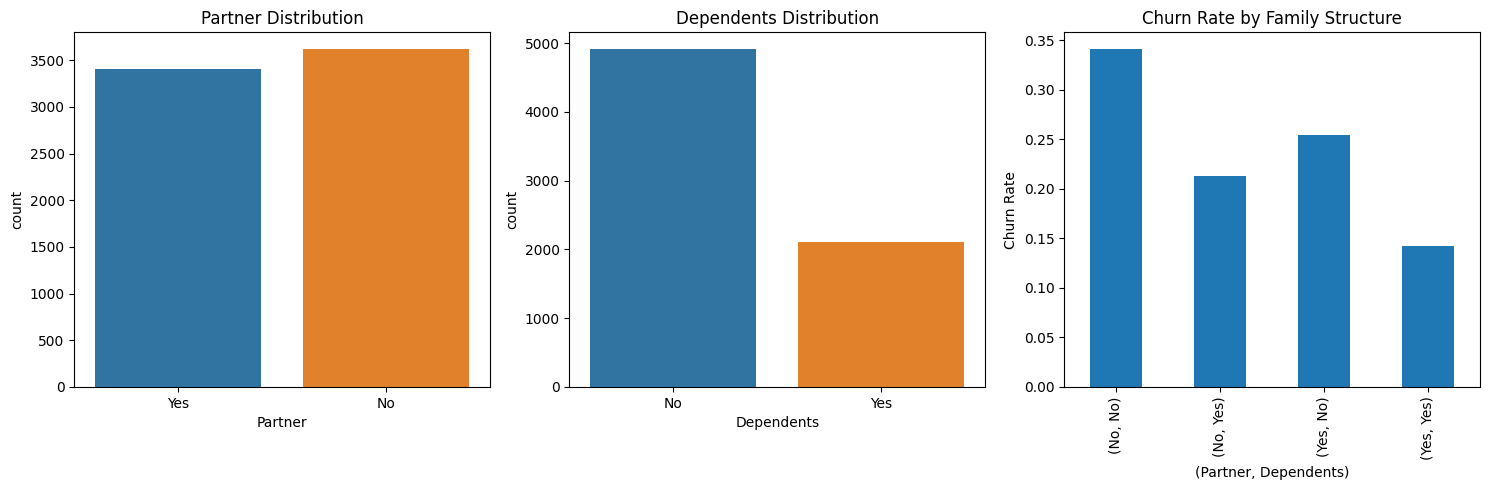

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x='Partner', data=df , hue='Partner')
plt.title('Partner Distribution')

plt.subplot(1, 3, 2)
sns.countplot(x='Dependents', data=df , hue='Dependents')
plt.title('Dependents Distribution')

plt.subplot(1, 3, 3)
partner_dependents = df.groupby(['Partner', 'Dependents'])['Churn'].value_counts(normalize=True).unstack()
partner_dependents['Yes'].plot(kind='bar')
plt.title('Churn Rate by Family Structure')
plt.xlabel('(Partner, Dependents)')
plt.ylabel('Churn Rate')
plt.tight_layout()
plt.show()

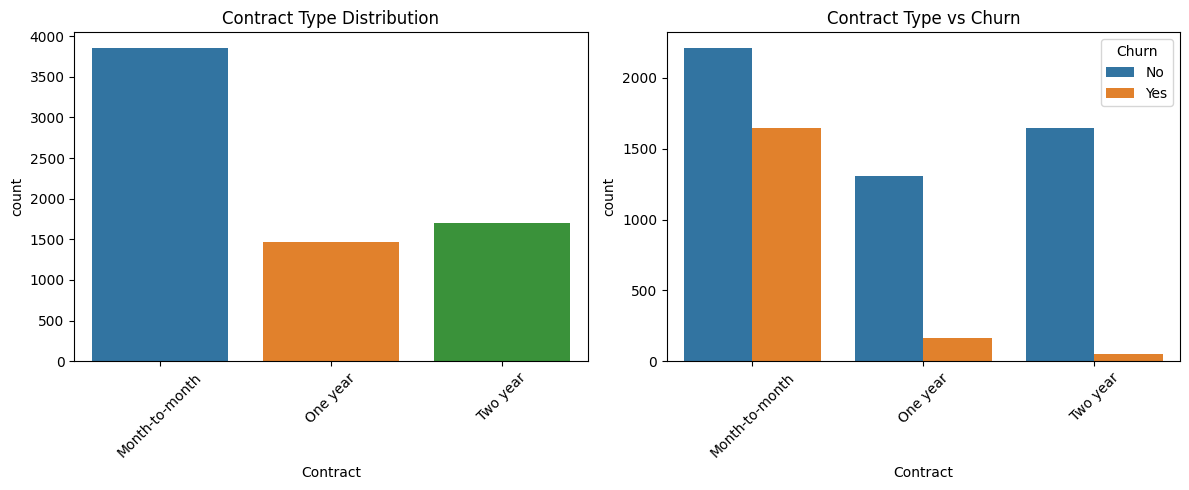

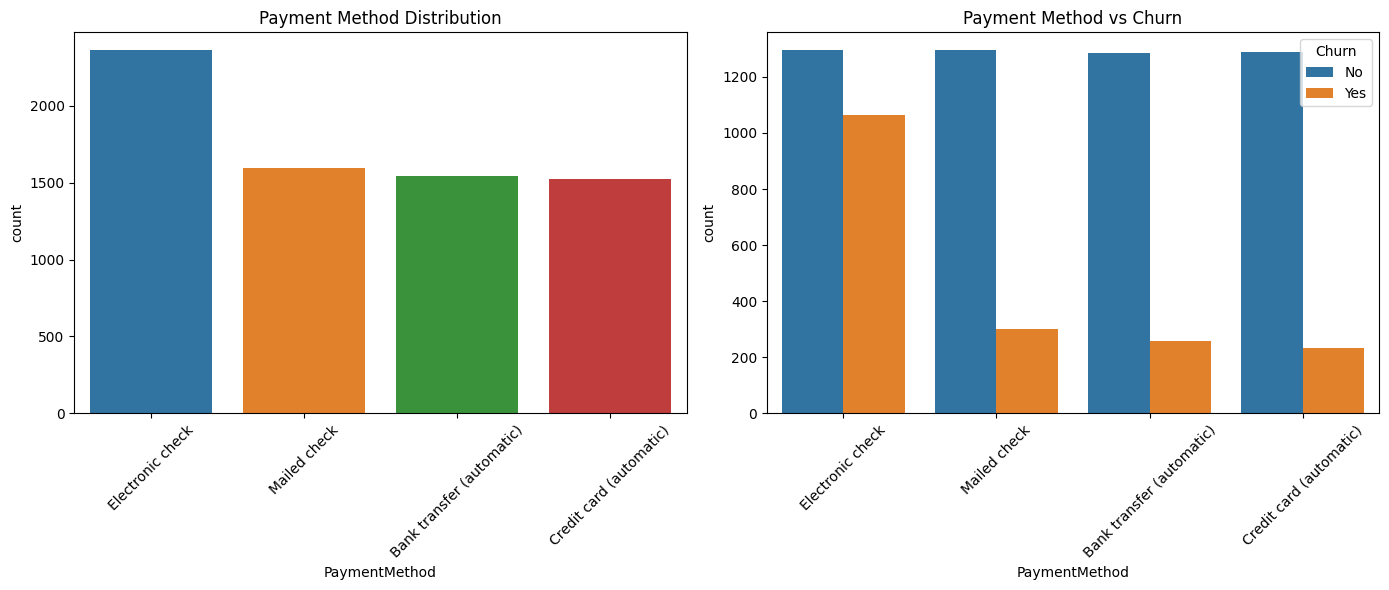

In [14]:
#Contract Type and Churn
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='Contract', data=df , hue='Contract')
plt.title('Contract Type Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Contract Type vs Churn')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Payment Method and Churn
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='PaymentMethod', data=df , hue='PaymentMethod')
plt.title('Payment Method Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(x='PaymentMethod', hue='Churn', data=df)
plt.title('Payment Method vs Churn')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Catégorisation de colonnes 'tenure'
def convert_to_buckets(tenure):
    if tenure <= 24:
        return '0-24 months'
    elif tenure <= 36:
        return '25-36 months'
    elif tenure <= 48:
        return '37-48 months'
    elif tenure <= 60:
        return '49-60 months'
    else:
        return '61+ months'

In [16]:
df['tenure'] = df['tenure'].apply(convert_to_buckets) # Appliquer la fonction de conversion à la colonne 'tenure'
df['tenure'].value_counts() # Afficher la distribution des valeurs de 'tenure'

tenure
0-24 months     3188
61+ months      1407
25-36 months     832
49-60 months     832
37-48 months     762
Name: count, dtype: int64

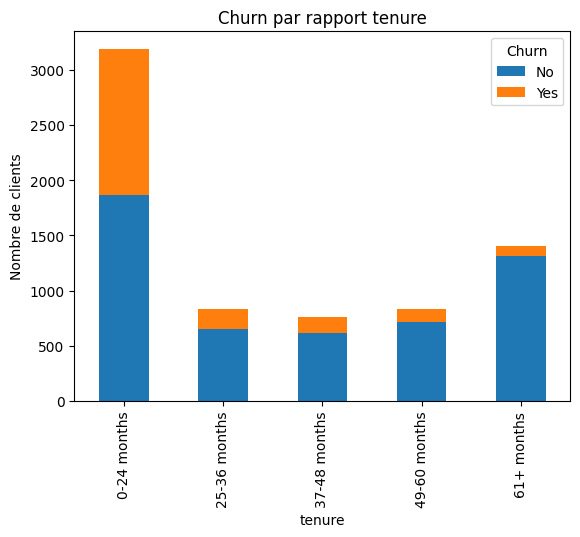

In [17]:
# Afficher la distribution des valeurs de 'tenure' par rapport à 'Churn'
df.groupby(['tenure','Churn']).size().unstack().plot(kind='bar',stacked=True)
plt.title('Churn par rapport tenure')
plt.xlabel('tenure')
plt.ylabel('Nombre de clients')
plt.show()

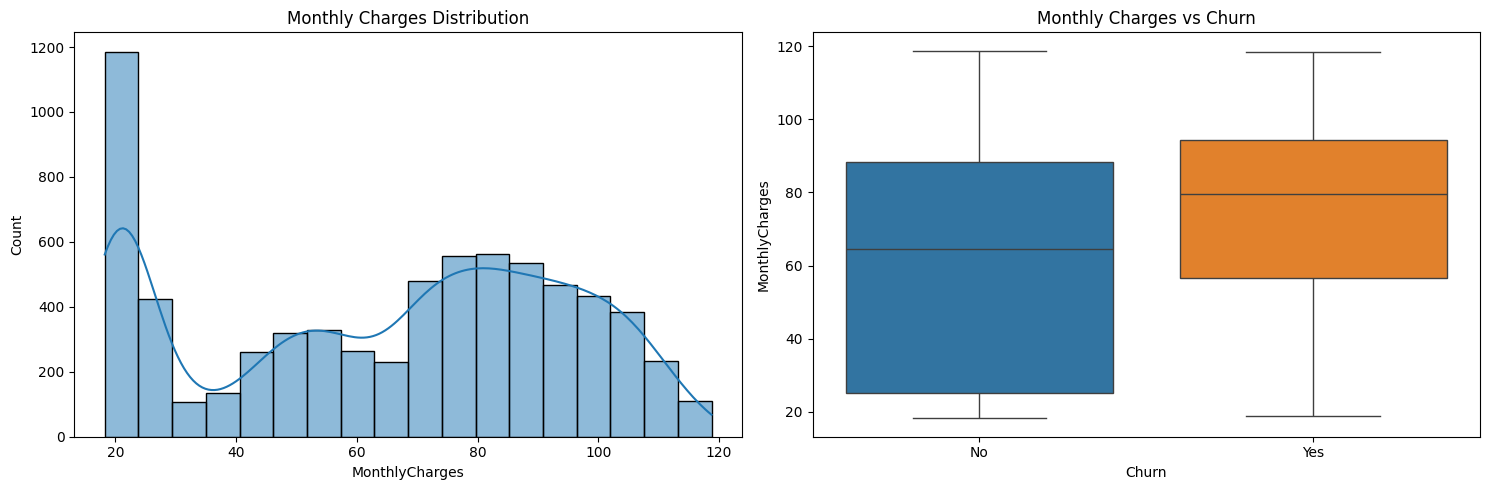

In [18]:
# Monthly Charges Distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['MonthlyCharges'], kde=True)
plt.title('Monthly Charges Distribution')

plt.subplot(1, 2, 2)
sns.boxplot(x='Churn', y='MonthlyCharges', data=df , hue='Churn')
plt.title('Monthly Charges vs Churn')

plt.tight_layout()
plt.show()

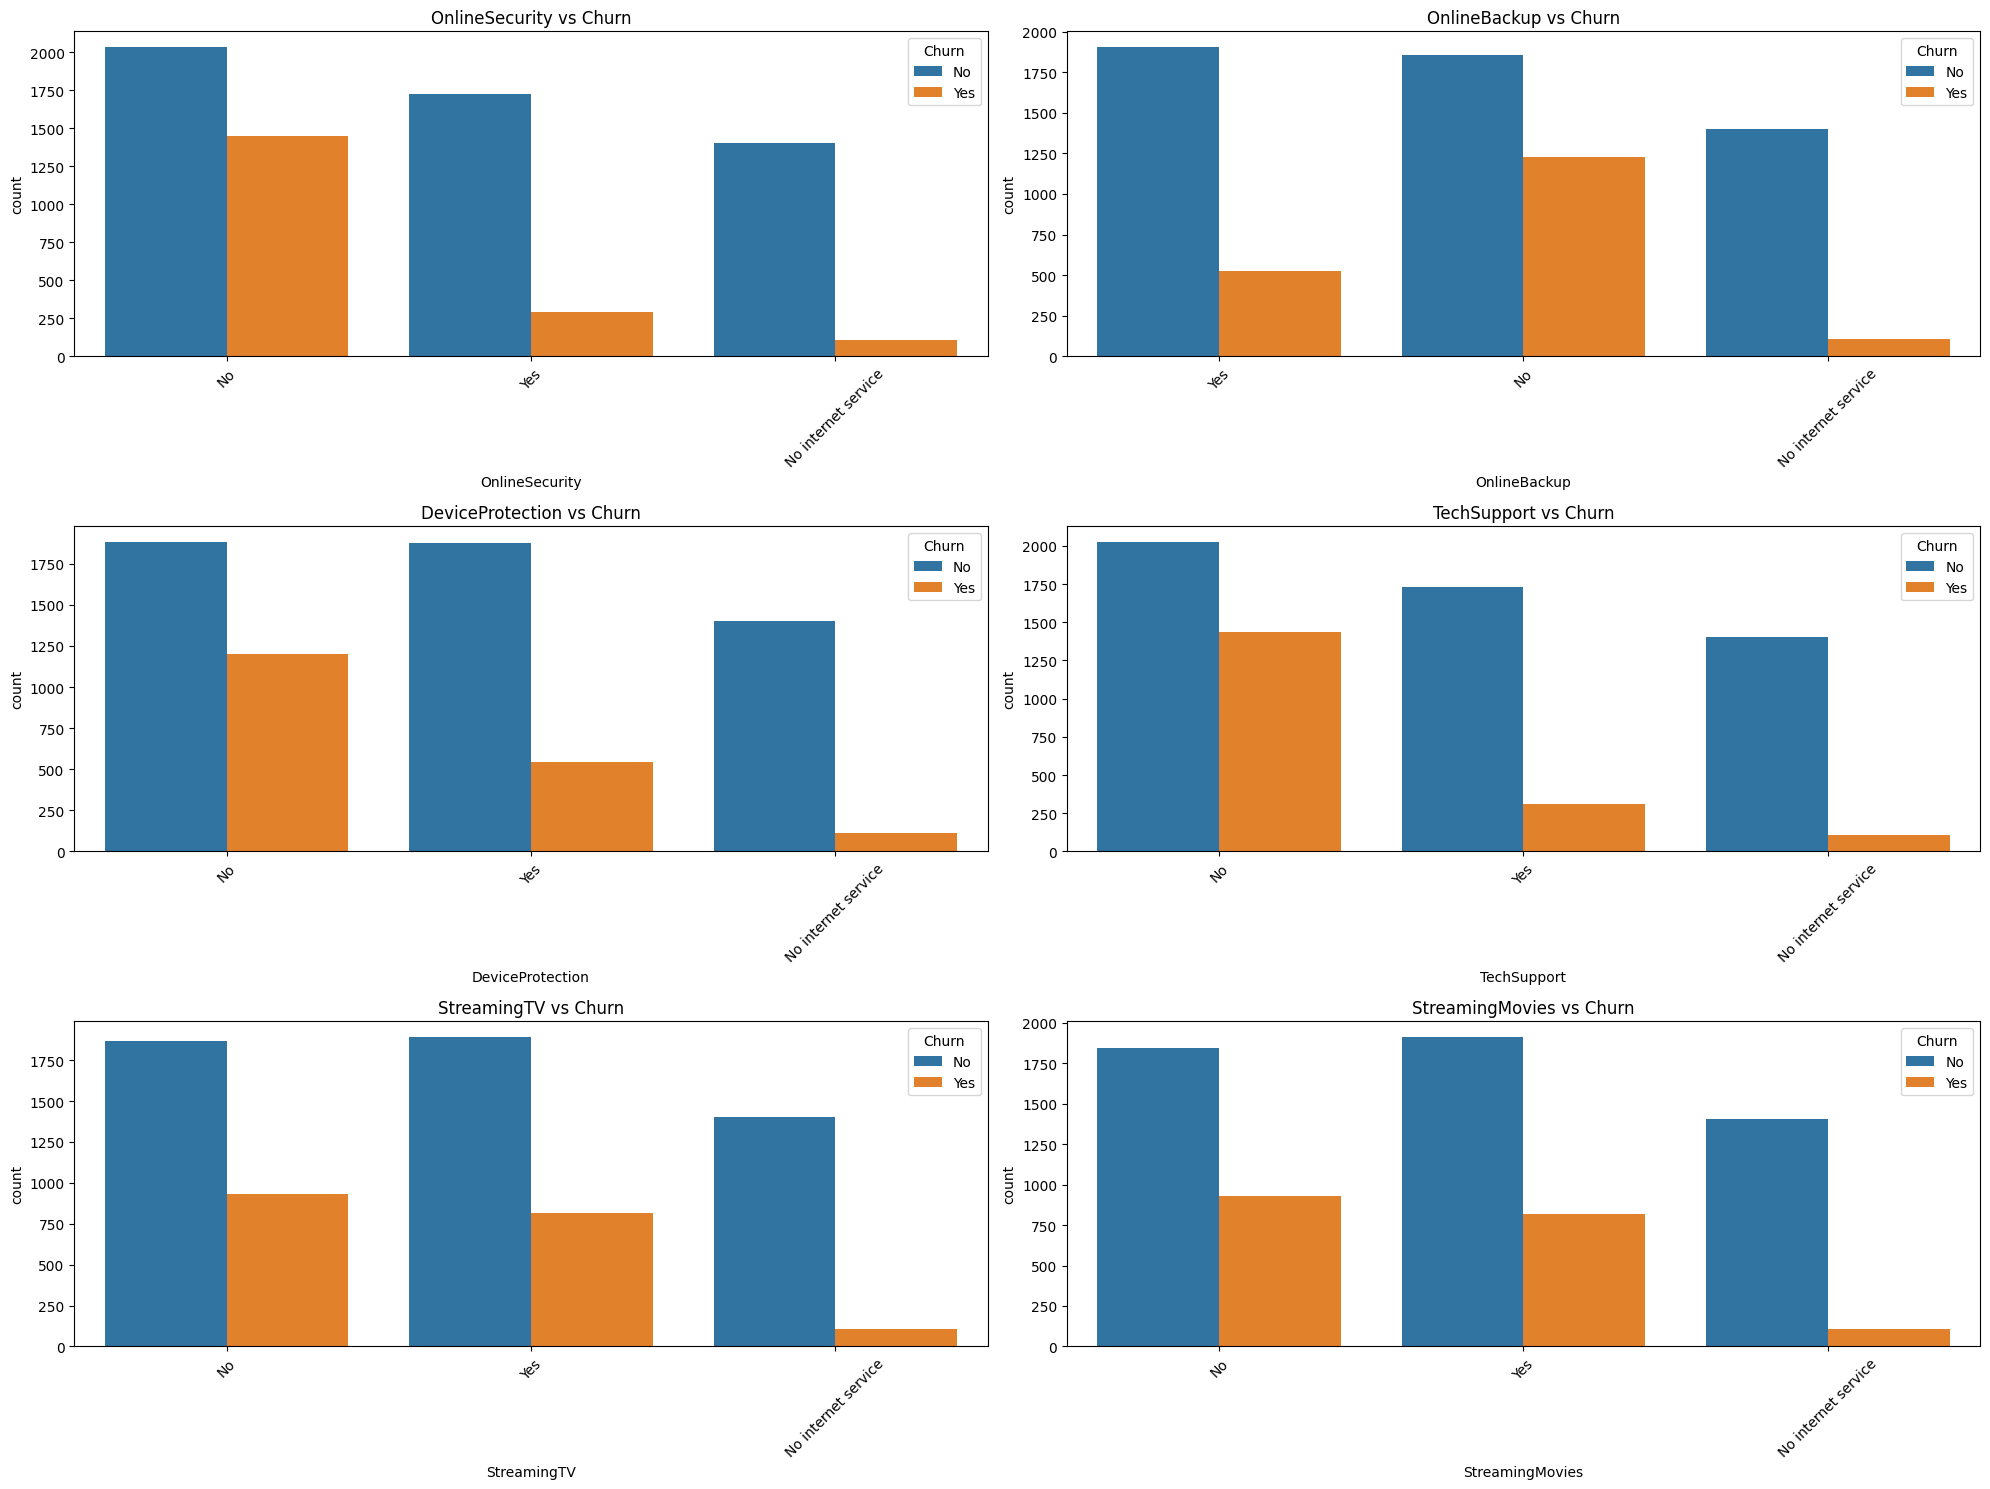

In [19]:
# Additional Services Analysis
additional_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

plt.figure(figsize=(20, 15))
for i, service in enumerate(additional_services, 1):
    plt.subplot(3, 2, i)
    sns.countplot(x=service, hue='Churn', data=df)
    plt.title(f'{service} vs Churn')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **4. Feature Engineering and Scaling:**

In [20]:
from sklearn.preprocessing import LabelEncoder

# Encoder les variables de type object
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Afficher les premières lignes du DataFrame encodé
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,0,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,1,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,2,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7021 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7021 non-null   int64  
 1   SeniorCitizen     7021 non-null   int64  
 2   Partner           7021 non-null   int64  
 3   Dependents        7021 non-null   int64  
 4   tenure            7021 non-null   int64  
 5   PhoneService      7021 non-null   int64  
 6   MultipleLines     7021 non-null   int64  
 7   InternetService   7021 non-null   int64  
 8   OnlineSecurity    7021 non-null   int64  
 9   OnlineBackup      7021 non-null   int64  
 10  DeviceProtection  7021 non-null   int64  
 11  TechSupport       7021 non-null   int64  
 12  StreamingTV       7021 non-null   int64  
 13  StreamingMovies   7021 non-null   int64  
 14  Contract          7021 non-null   int64  
 15  PaperlessBilling  7021 non-null   int64  
 16  PaymentMethod     7021 non-null   int64  
 17  

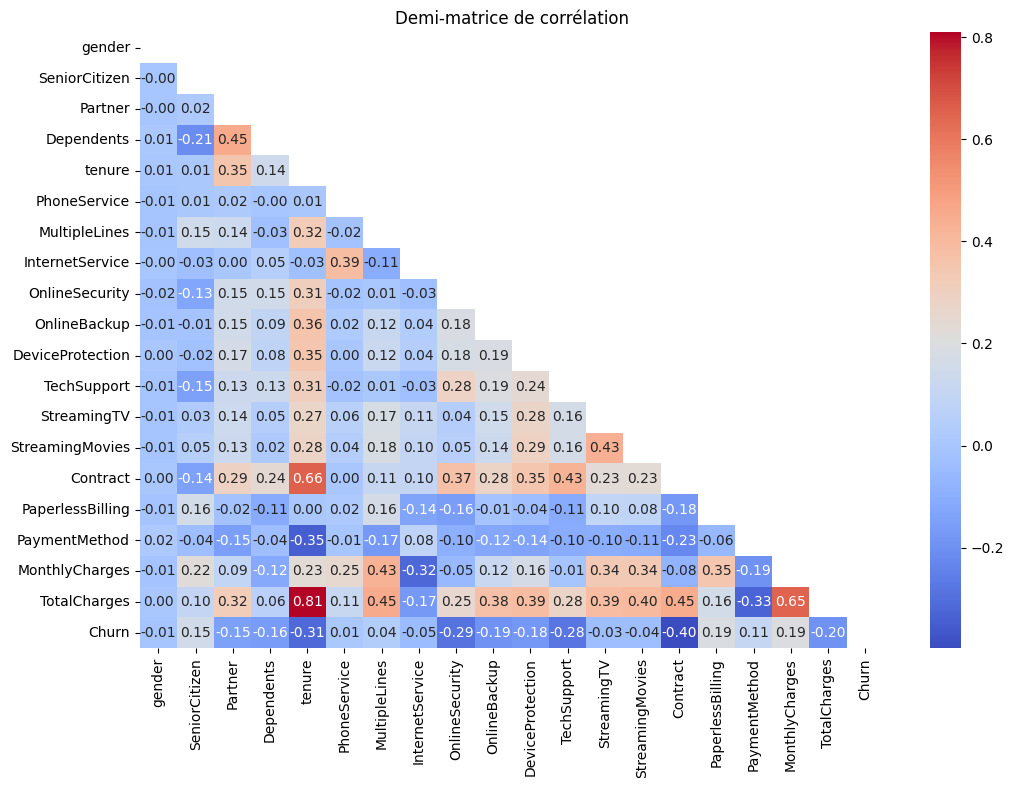

In [22]:
# Calculer la matrice de corrélation
correlation_matrix = df.corr()

# Masquer la moitié supérieure de la matrice
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Configurer la taille de la figure
plt.figure(figsize=(12, 8))

# Tracer la carte de chaleur
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Ajouter un titre
plt.title('Demi-matrice de corrélation')

# Afficher la figure
plt.show()

- `Interprétation :`
    - Cette matrice de corrélation montre que toutes les variables ne sont pas corrélées sauf *tenure* et *TotalCharges*. Pour cela, nous avons besoin de supprimer *TotalCharges*.

In [23]:
# Selection des caractéristiques et de la cible
X = df.drop(columns=['Churn' , 'TotalCharges']) # Variables explicatives
y = df['Churn'] # Variable cible

In [24]:
# Separation des données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% pour l'entraînement et 20% pour le test
# Afficher la taille des ensembles d'entraînement et de test
print(f'Taille de l\'ensemble d\'entraînement (X_train) : {X_train.shape}')
print(f'Taille de l\'ensemble de test (X_test) : {X_test.shape}')
print(f'Taille de l\'ensemble d\'entraînement (y_train) : {y_train.shape}')
print(f'Taille de l\'ensemble de test (y_test) : {y_test.shape}')


Taille de l'ensemble d'entraînement (X_train) : (5616, 18)
Taille de l'ensemble de test (X_test) : (1405, 18)
Taille de l'ensemble d'entraînement (y_train) : (5616,)
Taille de l'ensemble de test (y_test) : (1405,)


In [25]:
from sklearn.preprocessing import StandardScaler

# Initialiser le standardiseur
scaler = StandardScaler()

# Appliquer la standardisation sur les ensembles d'entraînement et de test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [89]:

print(X_train_scaled.shape , y_train.shape) 

(5616, 18) (5616,)


In [90]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Afficher la distribution des classes avant SMOTE
print("Distribution des classes avant SMOTE :", Counter(y_train))

# Initialiser SMOTE
smote = SMOTE(random_state=42)

# Appliquer SMOTE sur les données originales
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Afficher la distribution des classes après SMOTE
print("Distribution des classes après SMOTE :", Counter(y_train_smote))
print("Shape après SMOTE :", X_train_smote.shape, y_train_smote.shape)


Distribution des classes avant SMOTE : Counter({0: 4111, 1: 1505})
Distribution des classes après SMOTE : Counter({1: 4111, 0: 4111})
Shape après SMOTE : (8222, 18) (8222,)


## **4. Modeling :**

### *Regression Logistique :*

In [91]:
from sklearn.model_selection import StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor


CV = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False,)
    return(vif)

In [101]:


# Convert X_train_smote back to a DataFrame
X_train_smote_df = pd.DataFrame(X_train_smote, columns=X_train.columns)

# Check VIF
checkVIF(X_train_smote_df).reset_index(drop=True)

,Features,VIF
0,MonthlyCharges,2.81
1,tenure,2.64
2,Contract,2.62
3,PhoneService,1.78
4,InternetService,1.76
5,StreamingTV,1.48
6,Partner,1.48
7,StreamingMovies,1.47
8,Dependents,1.43
9,TechSupport,1.42


Logistic Regression - CV Accuracy: 0.7718 (±0.0114)
Logistic Regression - CV F1 Score: 0.7797 (±0.0107)
Logistic Regression - CV ROC-AUC: 0.8478 (±0.0114)
Random Forest - CV Accuracy: 0.8432 (±0.0121)
Random Forest - CV F1 Score: 0.8416 (±0.0128)
Random Forest - CV ROC-AUC: 0.9132 (±0.0091)


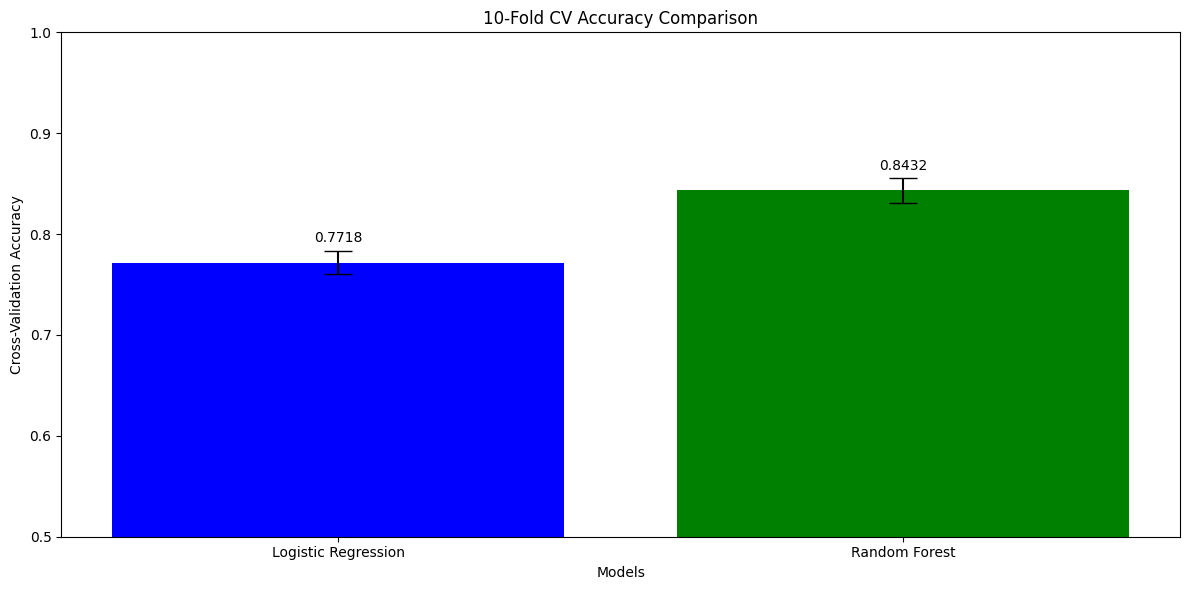

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


models_cv = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}


cv_results = {}
for name, model in models_cv.items():
    accuracy_scores = cross_val_score(model, X_train_smote, y_train_smote, cv=CV, scoring='accuracy')
    f1_scores = cross_val_score(model, X_train_smote, y_train_smote, cv=CV, scoring='f1')
    roc_auc_scores = cross_val_score(model, X_train_smote, y_train_smote, cv=CV, scoring='roc_auc')
    cv_results[name] = {
        'accuracy_mean': np.mean(accuracy_scores),
        'accuracy_std': np.std(accuracy_scores),
        'roc_auc_mean': np.mean(roc_auc_scores),
        'roc_auc_std': np.std(roc_auc_scores),
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores)
    }
    print(f"{name} - CV Accuracy: {cv_results[name]['accuracy_mean']:.4f} (±{cv_results[name]['accuracy_std']:.4f})")
    print(f"{name} - CV F1 Score: {cv_results[name]['f1_mean']:.4f} (±{cv_results[name]['f1_std']:.4f})")
    print(f"{name} - CV ROC-AUC: {cv_results[name]['roc_auc_mean']:.4f} (±{cv_results[name]['roc_auc_std']:.4f})")

# Accurary
plt.figure(figsize=(12, 6))
model_names = list(cv_results.keys())
accuracy_means = [res['accuracy_mean'] for res in cv_results.values()]
accuracy_stds = [res['accuracy_std'] for res in cv_results.values()]

plt.bar(model_names, accuracy_means, yerr=accuracy_stds, capsize=10, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Cross-Validation Accuracy')
plt.title('10-Fold CV Accuracy Comparison')
plt.ylim([0.5, 1.0])
for i, mean in enumerate(accuracy_means):
    plt.text(i, mean + 0.02, f'{mean:.4f}', ha='center')
plt.tight_layout()
plt.show()

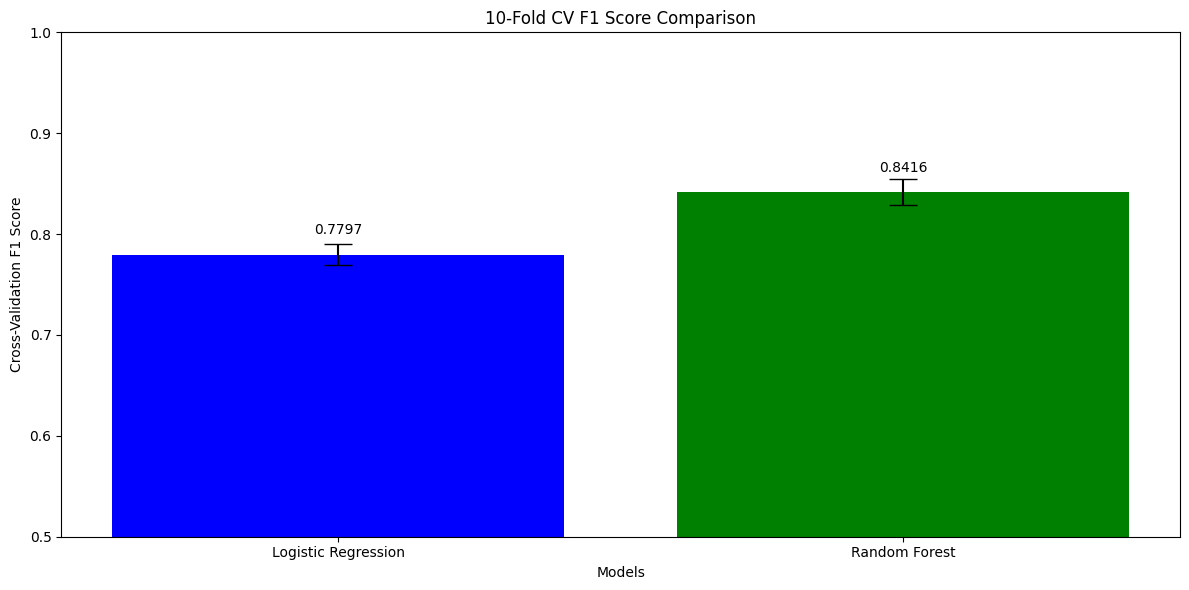

In [104]:
plt.figure(figsize=(12, 6))
f1_means = [res['f1_mean'] for res in cv_results.values()]
f1_stds = [res['f1_std'] for res in cv_results.values()]

plt.bar(model_names, f1_means, yerr=f1_stds, capsize=10, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Cross-Validation F1 Score')
plt.title('10-Fold CV F1 Score Comparison')
plt.ylim([0.5, 1.0]) 
for i, mean in enumerate(f1_means):
    plt.text(i, mean + 0.02, f'{mean:.4f}', ha='center')
plt.tight_layout()
plt.show()

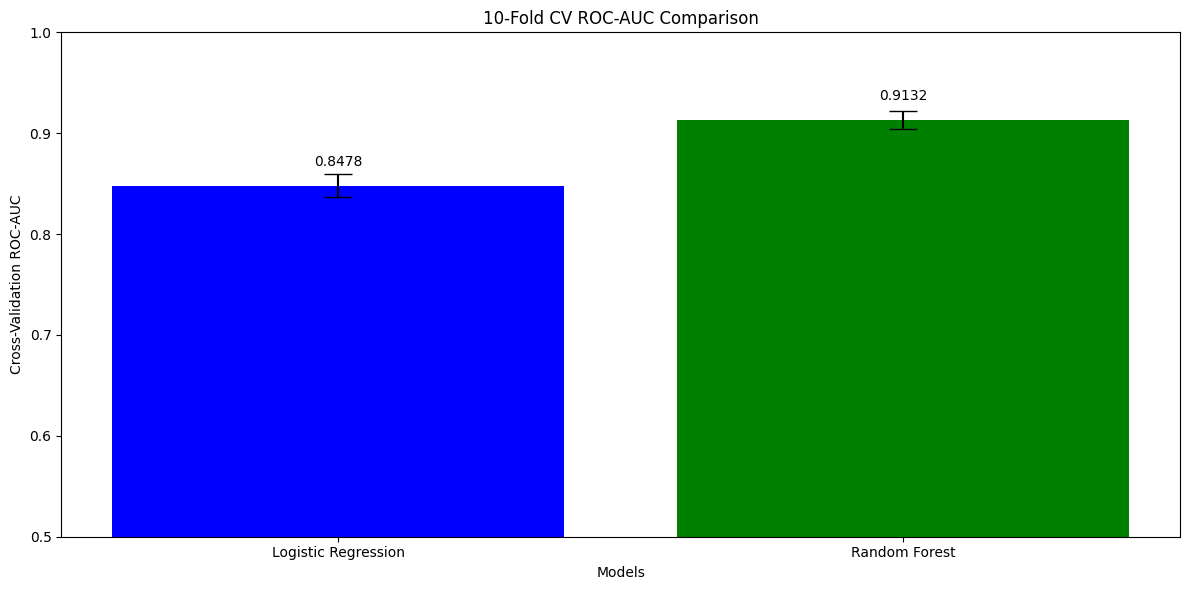

In [105]:
# ROC-AUC
plt.figure(figsize=(12, 6))
roc_auc_means = [res['roc_auc_mean'] for res in cv_results.values()]
roc_auc_stds = [res['roc_auc_std'] for res in cv_results.values()]

plt.bar(model_names, roc_auc_means, yerr=roc_auc_stds, capsize=10, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Cross-Validation ROC-AUC')
plt.title('10-Fold CV ROC-AUC Comparison')
plt.ylim([0.5, 1.0]) 
for i, mean in enumerate(roc_auc_means):
    plt.text(i, mean + 0.02, f'{mean:.4f}', ha='center')
plt.tight_layout()
plt.show()

In [106]:
for model_name, results in cv_results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {results['accuracy_mean']:.4f} (±{results['accuracy_std']:.4f})")
    print(f"F1-score: {results['f1_mean']:.4f} (±{results['f1_std']:.4f})")
    print(f"ROC-AUC: {results['roc_auc_mean']:.4f} (±{results['roc_auc_std']:.4f})")
    print()

Model: Logistic Regression
Accuracy: 0.7718 (±0.0114)
F1-score: 0.7797 (±0.0107)
ROC-AUC: 0.8478 (±0.0114)

Model: Random Forest
Accuracy: 0.8432 (±0.0121)
F1-score: 0.8416 (±0.0128)
ROC-AUC: 0.9132 (±0.0091)



c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



Random Forest Test Accuracy: 0.7687
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1053
           1       0.54      0.51      0.53       352

    accuracy                           0.77      1405
   macro avg       0.69      0.68      0.69      1405
weighted avg       0.77      0.77      0.77      1405



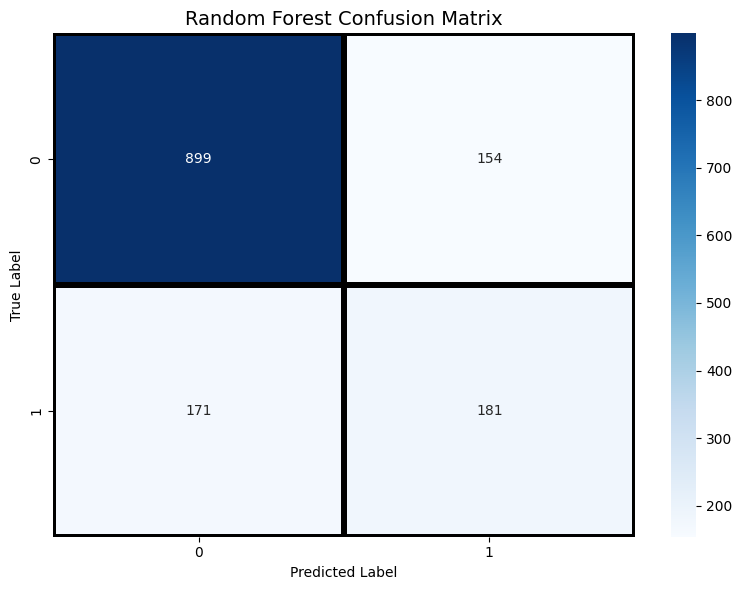

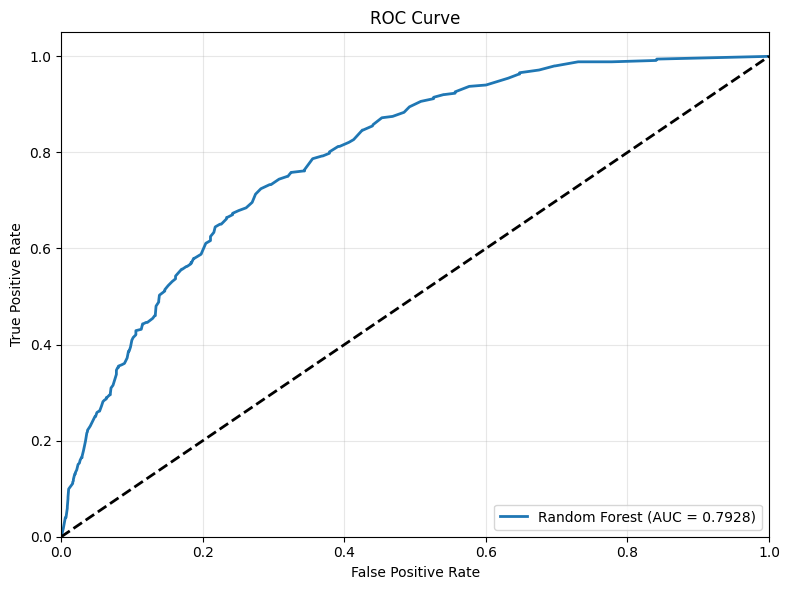

In [107]:

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve ,accuracy_score


best_model_name = "Random Forest"  # Random Forest model
best_model = models_cv[best_model_name]
best_model.fit(X_train_smote, y_train_smote)

y_pred = best_model.predict(X_test_scaled)
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"\n{best_model_name} Test Accuracy: {accuracy:.4f}")
print(report)

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', linecolor='k', linewidths=3, cmap='Blues')
plt.title(f'{best_model_name} Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'{best_model_name} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()